In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_excel("/content/drive/MyDrive/Bootcamp Llamadas Cobranza/Transcripciones_Variables.xlsx")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605 entries, 0 to 604
Data columns (total 10 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   archivo                                     605 non-null    object 
 1   duracion_seg                                605 non-null    float64
 2   transcripcion                               605 non-null    object 
 3   CONN_ID                                     592 non-null    object 
 4   AGENT_ID                                    592 non-null    float64
 5   SURVEY                                      592 non-null    object 
 6   1.1 Apertura de Llamada                     583 non-null    float64
 7   2.2 Alternativas de acuerdo a la necesidad  580 non-null    float64
 8   4.1 Condiciones de incumplimiento           572 non-null    float64
 9   4.2 Explica medios de pago                  506 non-null    float64
dtypes: float64(6),

In [5]:
pip install pandas numpy scikit-learn sentence-transformers transformers matplotlib

Clase positiva (minoritaria): 1
Distribución train:
 0    411
1     53
Name: count, dtype: int64
Distribución test:
 0    103
1     13
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (686 > 512). Running this sequence through the model will result in indexing errors



=== Embeddings MPNet + Logistic Regression (chunking seguro) ===
Umbral óptimo (pos=1): 0.591 | F1_pos: 0.3333

              precision    recall  f1-score   support

           0     0.9099    0.9806    0.9439       103
           1     0.6000    0.2308    0.3333        13

    accuracy                         0.8966       116
   macro avg     0.7550    0.6057    0.6386       116
weighted avg     0.8752    0.8966    0.8755       116

Matriz de confusión:
 [[101   2]
 [ 10   3]]
ROC-AUC: 0.5571 | PR-AUC (clase 1): 0.2415


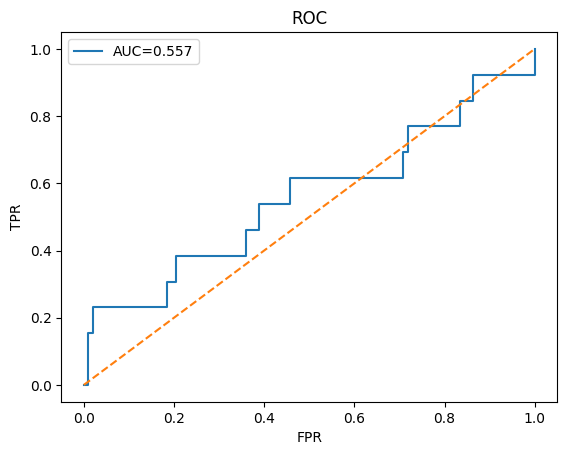

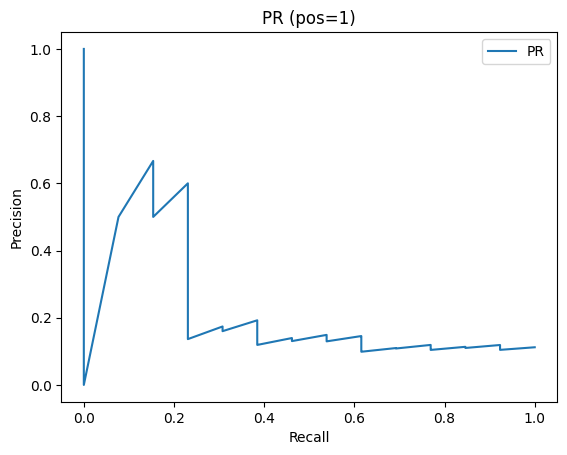

,transcripcion,y_true,prob_posclass,prob_label1,pred_label
415,Buenos días. Buenos días. El señor Miguel Ánge...,0,0.638508,0.638508,1
466,"Hola, buenas. Sí, hola, buenas. Sí, tan amable...",1,0.521026,0.521026,0
549,aló aló si buenas tan amables señor braz yanec...,0,0.511814,0.511814,0
517,"Muy buenos días, Christian Gaviotso, ¿sí? ¿Aló...",0,0.515384,0.515384,0
432,"Buenas tardes. Sí, buenas tardes. Gracias Dani...",0,0.494304,0.494304,0


In [6]:
# ============================
# EMBEDDINGS (MPNet) + LOGREG  (fix >512 tokens)
# Target: "2.2 Alternativas de acuerdo a la necesidad"
# Texto : "transcripción"
# ============================

import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, average_precision_score,
                             precision_recall_curve, roc_curve, auc)

# --- Config ---
TARGET = "2.2 Alternativas de acuerdo a la necesidad"
TEXT   = "transcripcion"
TEST_SIZE = 0.2
SEED = 42

EMB_MODEL = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
CHUNK_TOKENS = 480           # <=510 (sin especiales) para ir sobrados
CHUNK_STRIDE = 64

# --- Helpers mínimos ---
def clean(t):  # limpieza simple
    return re.sub(r"\s+"," ", str(t).strip())

def mean_embedding_safe(text, embedder, tok, max_len=CHUNK_TOKENS, stride=CHUNK_STRIDE):
    # Partimos por IDs sin special tokens para que al re-tokenizar no cambie el conteo.
    enc = tok(text, add_special_tokens=False, truncation=False)
    ids = enc["input_ids"]
    if isinstance(ids[0], list):  # por si devuelve batch
        ids = ids[0]

    chunks = []
    i = 0
    while i < len(ids):
        j = min(i + max_len, len(ids))
        chunk_ids = ids[i:j]
        # decode del MISMO tokenizer; luego embedder los tokeniza de nuevo y agrega especiales
        chunk_text = tok.decode(chunk_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        if chunk_text.strip():
            chunks.append(chunk_text)
        if j == len(ids): break
        i = max(j - stride, 0)

    if not chunks:  # por si texto muy corto
        chunks = [text]

    # Seguridad extra: limita la longitud interna de ST
    old_max = getattr(embedder, "max_seq_length", None)
    embedder.max_seq_length = 510

    E = embedder.encode(chunks, normalize_embeddings=True, show_progress_bar=False, batch_size=64)
    em = E.mean(axis=0)

    if old_max is not None:
        embedder.max_seq_length = old_max
    return em

# --- 0) Data prep ---
assert TARGET in df.columns, f"Falta columna target: {TARGET}"
assert TEXT   in df.columns, f"Falta columna texto: {TEXT}"

data = df[[TEXT, TARGET]].dropna().copy()
data[TEXT]   = data[TEXT].map(clean)
data[TARGET] = data[TARGET].astype(int)

train, test = train_test_split(
    data, test_size=TEST_SIZE, random_state=SEED, stratify=data[TARGET]
)
y_tr = train[TARGET].values
y_te = test[TARGET].values

# clase positiva = minoritaria (común en desbalance)
POS_CLASS = int(pd.Series(y_tr).value_counts().idxmin())
print(f"Clase positiva (minoritaria): {POS_CLASS}")
print("Distribución train:\n", pd.Series(y_tr).value_counts().sort_index())
print("Distribución test:\n", pd.Series(y_te).value_counts().sort_index())

# --- 1) Embeddings (chunking seguro) ---
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
embedder = SentenceTransformer(EMB_MODEL)
tok = AutoTokenizer.from_pretrained(EMB_MODEL)

X_tr = np.vstack([mean_embedding_safe(t, embedder, tok) for t in train[TEXT]])
X_te = np.vstack([mean_embedding_safe(t, embedder, tok) for t in test[TEXT]])

# --- 2) Logistic Regression (class weights) ---
cw = compute_class_weight("balanced", classes=np.array([0,1]), y=y_tr)
clf = LogisticRegression(max_iter=2000, solver="lbfgs", class_weight={0:float(cw[0]),1:float(cw[1])})
clf.fit(X_tr, y_tr)

# Prob etiqueta==1 y prob clase positiva
p_label1 = clf.predict_proba(X_te)[:,1]
p_pos    = p_label1 if POS_CLASS==1 else (1 - p_label1)

# Umbral óptimo por F1 de la clase positiva
prec, rec, thr = precision_recall_curve((y_te==POS_CLASS).astype(int), p_pos)
f1 = (2*prec[:-1]*rec[:-1])/(prec[:-1]+rec[:-1]+1e-12)
k = f1.argmax()
thr_opt, f1_best = float(thr[k]), float(f1[k])

yhat_pos = (p_pos >= thr_opt).astype(int)
yhat     = np.where(yhat_pos==1, POS_CLASS, 1-POS_CLASS)

# --- 3) Métricas ---
print("\n=== Embeddings MPNet + Logistic Regression (chunking seguro) ===")
print(f"Umbral óptimo (pos={POS_CLASS}): {thr_opt:.3f} | F1_pos: {f1_best:.4f}\n")
print(classification_report(y_te, yhat, digits=4))
print("Matriz de confusión:\n", confusion_matrix(y_te, yhat))

try:
    roc = roc_auc_score(y_te, p_label1)
    prc = average_precision_score((y_te==POS_CLASS).astype(int), p_pos)
    print(f"ROC-AUC: {roc:.4f} | PR-AUC (clase {POS_CLASS}): {prc:.4f}")
except:
    pass

# --- 4) Curvas (opcionales) ---
fpr,tpr,_ = roc_curve(y_te, p_label1, pos_label=1)
plt.figure(); plt.plot(fpr,tpr,label=f"AUC={auc(fpr,tpr):.3f}"); plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC"); plt.legend(); plt.show()

prec,rec,_ = precision_recall_curve((y_te==POS_CLASS).astype(int), p_pos)
plt.figure(); plt.plot(rec,prec,label="PR"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"PR (pos={POS_CLASS})"); plt.legend(); plt.show()

# --- 5) Predicciones de test ---
preds_test = test[[TEXT]].copy()
preds_test["y_true"] = y_te
preds_test["prob_posclass"] = p_pos
preds_test["prob_label1"]   = p_label1
preds_test["pred_label"]    = yhat
preds_test.head()


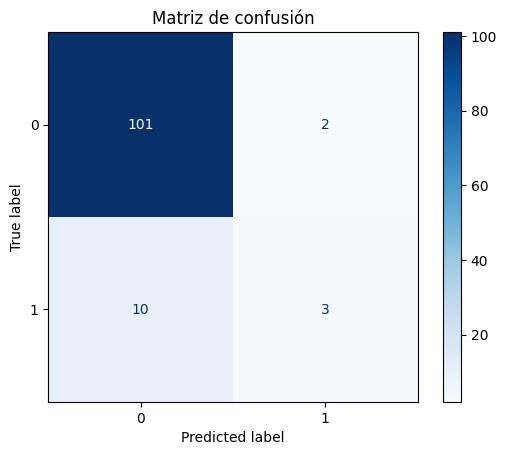

=== Métricas ===
Accuracy : 0.8966
Precision: 0.6000
Recall   : 0.2308
F1-score : 0.3333

=== Reporte detallado ===
              precision    recall  f1-score   support

           0     0.9099    0.9806    0.9439       103
           1     0.6000    0.2308    0.3333        13

    accuracy                         0.8966       116
   macro avg     0.7550    0.6057    0.6386       116
weighted avg     0.8752    0.8966    0.8755       116



In [7]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, accuracy_score, precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt

# --- Matriz de confusión ---
cm = confusion_matrix(y_te, yhat, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap="Blues", values_format="d")
plt.title("Matriz de confusión")
plt.show()

# --- Métricas básicas ---
acc  = accuracy_score(y_te, yhat)
prec = precision_score(y_te, yhat, pos_label=1)
rec  = recall_score(y_te, yhat, pos_label=1)
f1   = f1_score(y_te, yhat, pos_label=1)

print("=== Métricas ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

# --- Reporte detallado (por clase) ---
print("\n=== Reporte detallado ===")
print(classification_report(y_te, yhat, digits=4))

In [8]:
plt.savefig("roc_curve.png")
plt.savefig("pr_curve.png")

<Figure size 640x480 with 0 Axes>

Token indices sequence length is longer than the specified maximum sequence length for this model (686 > 512). Running this sequence through the model will result in indexing errors


Distribución train: {0: 411, 1: 53}
Distribución test : {0: 103, 1: 13}


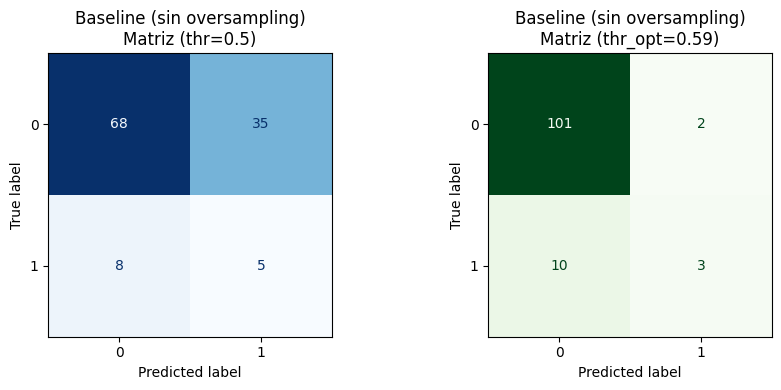


=== Baseline (sin oversampling) ===
[thr=0.5 ] Acc=0.629 | Prec=0.125 | Rec=0.385 | F1=0.189
[thr_opt ] Acc=0.897 | Prec=0.600 | Rec=0.231 | F1=0.333 (thr=0.59)


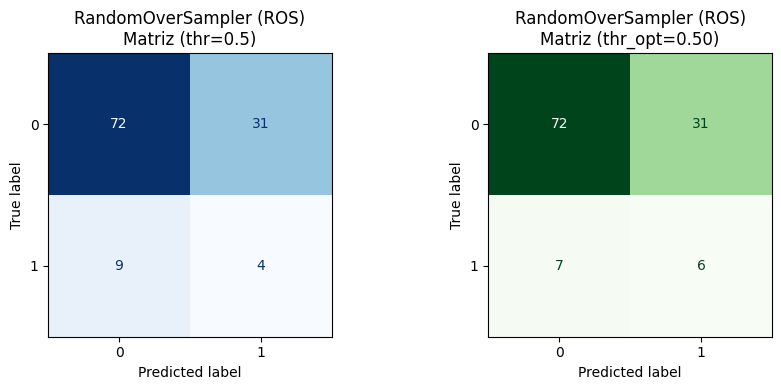


=== RandomOverSampler (ROS) ===
[thr=0.5 ] Acc=0.655 | Prec=0.114 | Rec=0.308 | F1=0.167
[thr_opt ] Acc=0.672 | Prec=0.162 | Rec=0.462 | F1=0.240 (thr=0.50)


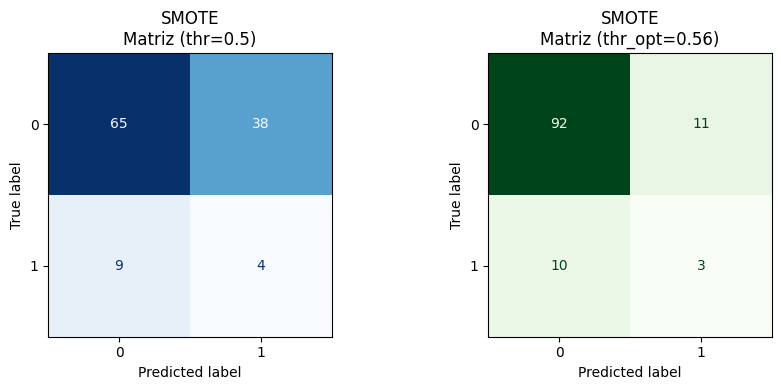


=== SMOTE ===
[thr=0.5 ] Acc=0.595 | Prec=0.095 | Rec=0.308 | F1=0.145
[thr_opt ] Acc=0.819 | Prec=0.214 | Rec=0.231 | F1=0.222 (thr=0.56)


,experimento,thr_0.5,acc_0.5,prec_0.5,rec_0.5,f1_0.5,thr_opt,acc_opt,prec_opt,rec_opt,f1_opt
1,RandomOverSampler (ROS),0.5,0.655172,0.114286,0.307692,0.166667,0.499208,0.672414,0.162162,0.461538,0.240000
0,Baseline (sin oversampling),0.5,0.629310,0.125000,0.384615,0.188679,0.590784,0.896552,0.600000,0.230769,0.333333
2,SMOTE,0.5,0.594828,0.095238,0.307692,0.145455,0.555740,0.818966,0.214286,0.230769,0.222222


In [9]:
# ============================================================
# Oversampling (ROS / SMOTE) + Logistic Regression sobre embeddings
# Texto: "transcripción" (cambia a "transcripcion" si es tu caso)
# Target: "2.2 Alternativas de acuerdo a la necesidad" (0/1)
# ============================================================
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             accuracy_score, precision_score, recall_score, f1_score,
                             precision_recall_curve)
from imblearn.over_sampling import RandomOverSampler, SMOTE

# ---------- CONFIG ----------
TEXT   = "transcripcion"
TARGET = "2.2 Alternativas de acuerdo a la necesidad"
TEST_SIZE = 0.2
SEED = 42
EMB_MODEL = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
CHUNK_TOKENS = 480
CHUNK_STRIDE = 64

# ---------- Helpers mínimos ----------
def clean(t): return re.sub(r"\s+"," ", str(t).strip())

def best_thr_f1_pos(y_true, p_pos):
    """Umbral que maximiza F1 de la clase positiva (1)."""
    y_bin = (y_true==1).astype(int)
    prec, rec, thr = precision_recall_curve(y_bin, p_pos)
    f1 = (2*prec[:-1]*rec[:-1])/(prec[:-1]+rec[:-1]+1e-12)
    k = f1.argmax()
    return float(thr[k]), float(f1[k])

# Embedding robusto a textos largos
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
embedder = SentenceTransformer(EMB_MODEL); embedder.max_seq_length = 510
tok = AutoTokenizer.from_pretrained(EMB_MODEL)

def embed_ultrasafe(text, max_len=CHUNK_TOKENS, stride=CHUNK_STRIDE):
    ids = tok(text, add_special_tokens=False, truncation=False)["input_ids"]
    if isinstance(ids[0], list): ids = ids[0]
    safe_chunks, i = [], 0
    while i < len(ids):
        j = min(i + max_len, len(ids))
        chunk_txt = tok.decode(ids[i:j], skip_special_tokens=True, clean_up_tokenization_spaces=True)
        tok2 = tok(chunk_txt, add_special_tokens=True, truncation=True, max_length=510)
        chunk_txt_safe = tok.decode(tok2["input_ids"], skip_special_tokens=True, clean_up_tokenization_spaces=True)
        if chunk_txt_safe.strip(): safe_chunks.append(chunk_txt_safe)
        if j == len(ids): break
        i = max(j - stride, 0)
    if not safe_chunks: safe_chunks = [text]
    E = embedder.encode(safe_chunks, normalize_embeddings=True, batch_size=64, show_progress_bar=False)
    return E.mean(axis=0)

# ---------- 0) Datos ----------
assert TARGET in df.columns and TEXT in df.columns, "Revisa nombres de columnas."
data = df[[TEXT, TARGET]].dropna().copy()
data[TEXT] = data[TEXT].map(clean)
data[TARGET] = data[TARGET].astype(int)

train, test = train_test_split(data, test_size=TEST_SIZE, random_state=SEED, stratify=data[TARGET])
y_tr = train[TARGET].values
y_te = test[TARGET].values

print("Distribución train:", pd.Series(y_tr).value_counts().sort_index().to_dict())
print("Distribución test :", pd.Series(y_te).value_counts().sort_index().to_dict())

# ---------- 1) Embeddings ----------
X_tr = np.vstack([embed_ultrasafe(t) for t in train[TEXT]])
X_te = np.vstack([embed_ultrasafe(t) for t in test[TEXT]])

# ---------- 2) Experimentos ----------
experimentos = [
    ("Baseline (sin oversampling)", None),
    ("RandomOverSampler (ROS)", RandomOverSampler(random_state=SEED)),
    ("SMOTE", SMOTE(random_state=SEED, k_neighbors=3)),
]

resultados = []

for nombre, sampler in experimentos:
    # Resample (si aplica)
    if sampler is None:
        Xtr_use, ytr_use = X_tr, y_tr
        class_weight = "balanced"   # sin oversampling, usamos pesos
    else:
        Xtr_use, ytr_use = sampler.fit_resample(X_tr, y_tr)
        class_weight = None         # ya balanceado, no usar pesos

    # Entrena LR
    clf = LogisticRegression(max_iter=2000, solver="lbfgs", class_weight=class_weight)
    clf.fit(Xtr_use, ytr_use)

    # Prob de etiqueta==1 (positiva)
    p1 = clf.predict_proba(X_te)[:,1]

    # Eval con threshold 0.5
    yhat_05 = (p1 >= 0.5).astype(int)
    acc05  = accuracy_score(y_te, yhat_05)
    prec05 = precision_score(y_te, yhat_05, zero_division=0)
    rec05  = recall_score(y_te, yhat_05, zero_division=0)
    f105   = f1_score(y_te, yhat_05, zero_division=0)

    # Eval con threshold óptimo (F1 clase 1)
    thr_opt, f1opt = best_thr_f1_pos(y_te, p1)
    yhat_opt = (p1 >= thr_opt).astype(int)
    accop  = accuracy_score(y_te, yhat_opt)
    precop = precision_score(y_te, yhat_opt, zero_division=0)
    recop  = recall_score(y_te, yhat_opt, zero_division=0)
    f1op   = f1_score(y_te, yhat_opt, zero_division=0)

    resultados.append({
        "experimento": nombre,
        "thr_0.5": 0.5, "acc_0.5": acc05, "prec_0.5": prec05, "rec_0.5": rec05, "f1_0.5": f105,
        "thr_opt": thr_opt, "acc_opt": accop, "prec_opt": precop, "rec_opt": recop, "f1_opt": f1op
    })

    # --- Plots rápidos de confusión ---
    fig, ax = plt.subplots(1,2, figsize=(9,4))
    cm05 = confusion_matrix(y_te, yhat_05, labels=[0,1])
    cmop = confusion_matrix(y_te, yhat_opt, labels=[0,1])
    ConfusionMatrixDisplay(cm05, display_labels=[0,1]).plot(cmap="Blues", values_format="d", ax=ax[0], colorbar=False)
    ax[0].set_title(f"{nombre}\nMatriz (thr=0.5)")
    ConfusionMatrixDisplay(cmop, display_labels=[0,1]).plot(cmap="Greens", values_format="d", ax=ax[1], colorbar=False)
    ax[1].set_title(f"{nombre}\nMatriz (thr_opt={thr_opt:.2f})")
    plt.tight_layout(); plt.show()

    # Reporte resumido
    print(f"\n=== {nombre} ===")
    print(f"[thr=0.5 ] Acc={acc05:.3f} | Prec={prec05:.3f} | Rec={rec05:.3f} | F1={f105:.3f}")
    print(f"[thr_opt ] Acc={accop:.3f} | Prec={precop:.3f} | Rec={recop:.3f} | F1={f1op:.3f} (thr={thr_opt:.2f})")

# ---------- 3) Tabla comparativa ----------
df_res = pd.DataFrame(resultados)
display(df_res.sort_values("rec_opt", ascending=False))

Distribución train: {0: 411, 1: 53}
Distribución test : {0: 103, 1: 13}


Token indices sequence length is longer than the specified maximum sequence length for this model (686 > 512). Running this sequence through the model will result in indexing errors


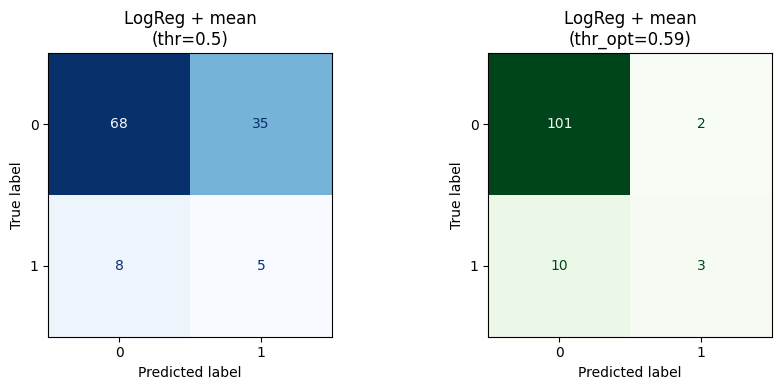

[LightGBM] [Info] Number of positive: 53, number of negative: 411
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 119258
[LightGBM] [Info] Number of data points in the train set: 464, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.114224 -> initscore=-2.048301
[LightGBM] [Info] Start training from score -2.048301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


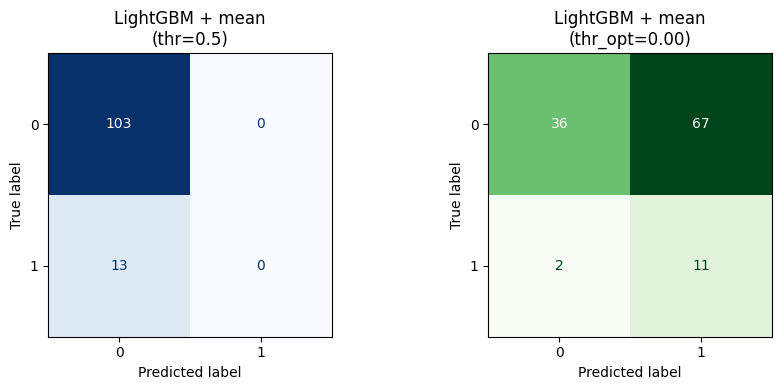

[LightGBM] [Info] Number of positive: 53, number of negative: 411
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 119197
[LightGBM] [Info] Number of data points in the train set: 464, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.114224 -> initscore=-2.048301
[LightGBM] [Info] Start training from score -2.048301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


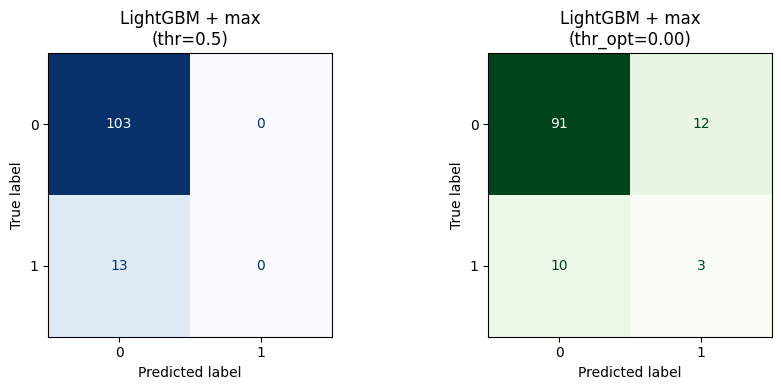

[LightGBM] [Info] Number of positive: 411, number of negative: 411
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195731
[LightGBM] [Info] Number of data points in the train set: 822, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


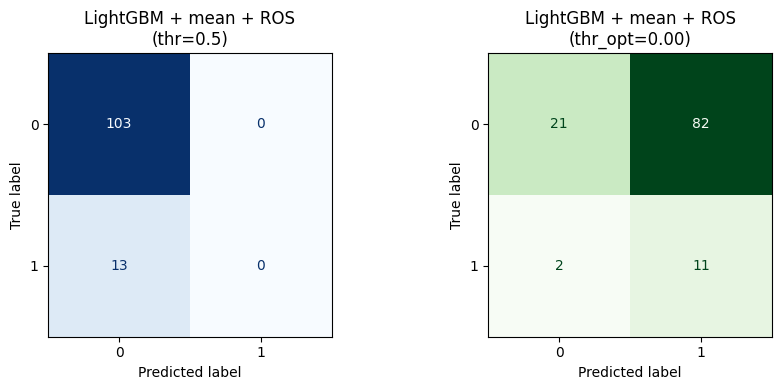

,experimento,pool,thr_0.5,acc_0.5,prec_0.5,rec_0.5,f1_0.5,thr_opt,acc_opt,prec_opt,rec_opt,f1_opt
1,LightGBM + mean,mean,0.5,0.887931,0.000,0.000000,0.000000,0.000068,0.405172,0.141026,0.846154,0.241758
3,LightGBM + mean + ROS,mean,0.5,0.887931,0.000,0.000000,0.000000,0.000029,0.275862,0.118280,0.846154,0.207547
0,LogReg + mean,mean,0.5,0.629310,0.125,0.384615,0.188679,0.590784,0.896552,0.600000,0.230769,0.333333
2,LightGBM + max,max,0.5,0.887931,0.000,0.000000,0.000000,0.004148,0.810345,0.200000,0.230769,0.214286


In [10]:
# ============================================================
# Comparativo: LogReg vs LightGBM con mean/max pooling (+ROS)
# Texto  : "transcripción" (cambia si es "transcripcion")
# Target : "2.2 Alternativas de acuerdo a la necesidad" (0/1)
# ============================================================
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                             accuracy_score, precision_score, recall_score, f1_score,
                             precision_recall_curve)
from imblearn.over_sampling import RandomOverSampler

TEXT   = "transcripcion"
TARGET = "2.2 Alternativas de acuerdo a la necesidad"
TEST_SIZE = 0.2
SEED = 42

EMB_MODEL = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
CHUNK_TOKENS = 480
CHUNK_STRIDE = 64

# ---------- Helpers mínimos ----------
def clean(t): return re.sub(r"\s+"," ", str(t).strip())

def best_thr_f1_pos(y_true, p_pos):
    y_bin = (y_true==1).astype(int)
    prec, rec, thr = precision_recall_curve(y_bin, p_pos)
    f1 = (2*prec[:-1]*rec[:-1])/(prec[:-1]+rec[:-1]+1e-12)
    k = f1.argmax()
    return float(thr[k]), float(f1[k])

# ---------- Datos ----------
assert TARGET in df.columns and TEXT in df.columns, "Revisa nombres de columnas."
data = df[[TEXT, TARGET]].dropna().copy()
data[TEXT] = data[TEXT].map(clean)
data[TARGET] = data[TARGET].astype(int)

train, test = train_test_split(data, test_size=TEST_SIZE, random_state=SEED, stratify=data[TARGET])
y_tr = train[TARGET].values
y_te = test[TARGET].values
print("Distribución train:", pd.Series(y_tr).value_counts().sort_index().to_dict())
print("Distribución test :", pd.Series(y_te).value_counts().sort_index().to_dict())

# ---------- Embeddings con chunking seguro ----------
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
embedder = SentenceTransformer(EMB_MODEL); embedder.max_seq_length = 510
tok = AutoTokenizer.from_pretrained(EMB_MODEL)

def chunks_embeddings(text, max_len=CHUNK_TOKENS, stride=CHUNK_STRIDE):
    # 1) cortamos por IDs sin especiales
    ids = tok(text, add_special_tokens=False, truncation=False)["input_ids"]
    if isinstance(ids[0], list): ids = ids[0]
    safe_chunks, i = [], 0
    while i < len(ids):
        j = min(i + max_len, len(ids))
        chunk_txt = tok.decode(ids[i:j], skip_special_tokens=True, clean_up_tokenization_spaces=True)
        # 2) re-tokenizamos con truncation a 510 (con especiales)
        tok2 = tok(chunk_txt, add_special_tokens=True, truncation=True, max_length=510)
        chunk_txt_safe = tok.decode(tok2["input_ids"], skip_special_tokens=True, clean_up_tokenization_spaces=True)
        if chunk_txt_safe.strip(): safe_chunks.append(chunk_txt_safe)
        if j == len(ids): break
        i = max(j - stride, 0)
    if not safe_chunks: safe_chunks = [text]
    E = embedder.encode(safe_chunks, normalize_embeddings=True, batch_size=64, show_progress_bar=False)
    return E  # (n_chunks, dim)

# Precompute embeddings por documento (una sola vez)
Em_tr_list = [chunks_embeddings(t) for t in train[TEXT]]
Em_te_list = [chunks_embeddings(t) for t in test[TEXT]]

# Poolings
X_tr_mean = np.vstack([E.mean(axis=0) for E in Em_tr_list])
X_te_mean = np.vstack([E.mean(axis=0) for E in Em_te_list])

X_tr_max = np.vstack([E.max(axis=0) for E in Em_tr_list])
X_te_max = np.vstack([E.max(axis=0) for E in Em_te_list])

# ---------- Modelos ----------
import lightgbm as lgb

experimentos = [
    ("LogReg + mean", "logreg", "mean", None),
    ("LightGBM + mean", "lgbm", "mean", None),
    ("LightGBM + max", "lgbm", "max", None),
    ("LightGBM + mean + ROS", "lgbm", "mean", "ros"),
]

def get_X(pool, split):
    if pool=="mean" and split=="train": return X_tr_mean
    if pool=="mean" and split=="test":  return X_te_mean
    if pool=="max"  and split=="train": return X_tr_max
    if pool=="max"  and split=="test":  return X_te_max
    raise ValueError

resultados = []

for nombre, modelo, pool, sampler in experimentos:
    Xtr = get_X(pool, "train"); Xte = get_X(pool, "test")

    # Oversampling si aplica
    if sampler == "ros":
        ros = RandomOverSampler(random_state=SEED)
        Xtr_use, ytr_use = ros.fit_resample(Xtr, y_tr)
        class_weight = None
        spw = None
    else:
        Xtr_use, ytr_use = Xtr, y_tr
        class_weight = "balanced" if modelo=="logreg" else None
        # scale_pos_weight para LGBM (el desbalance real)
        n_pos = (ytr_use==1).sum(); n_neg = len(ytr_use)-n_pos
        spw = max(n_neg / max(n_pos,1), 1.0) if modelo=="lgbm" else None

    # Entrena
    if modelo=="logreg":
        clf = LogisticRegression(max_iter=2000, solver="lbfgs", class_weight=class_weight)
        clf.fit(Xtr_use, ytr_use)
        p1 = clf.predict_proba(Xte)[:,1]
    else:  # lgbm
        clf = lgb.LGBMClassifier(
            n_estimators=700, learning_rate=0.05, num_leaves=63,
            subsample=0.9, colsample_bytree=0.9, random_state=SEED,
            objective="binary", scale_pos_weight=spw
        )
        clf.fit(Xtr_use, ytr_use)
        p1 = clf.predict_proba(Xte)[:,1]

    # Métricas thr=0.5
    yhat05 = (p1 >= 0.5).astype(int)
    acc05, prec05, rec05, f105 = (accuracy_score(y_te,yhat05),
                                  precision_score(y_te,yhat05,zero_division=0),
                                  recall_score(y_te,yhat05,zero_division=0),
                                  f1_score(y_te,yhat05,zero_division=0))
    # Métricas thr óptimo (F1 clase 1)
    thr_opt, _ = best_thr_f1_pos(y_te, p1)
    yhatop = (p1 >= thr_opt).astype(int)
    accop, precop, recop, f1op = (accuracy_score(y_te,yhatop),
                                  precision_score(y_te,yhatop,zero_division=0),
                                  recall_score(y_te,yhatop,zero_division=0),
                                  f1_score(y_te,yhatop,zero_division=0))

    resultados.append({
        "experimento": nombre, "pool": pool,
        "thr_0.5": 0.5, "acc_0.5": acc05, "prec_0.5": prec05, "rec_0.5": rec05, "f1_0.5": f105,
        "thr_opt": thr_opt, "acc_opt": accop, "prec_opt": precop, "rec_opt": recop, "f1_opt": f1op
    })

    # Matrices de confusión (opcional, comenta si no quieres plots)
    fig, ax = plt.subplots(1,2, figsize=(9,4))
    ConfusionMatrixDisplay(confusion_matrix(y_te, yhat05)).plot(cmap="Blues", values_format="d", ax=ax[0], colorbar=False)
    ax[0].set_title(f"{nombre}\n(thr=0.5)")
    ConfusionMatrixDisplay(confusion_matrix(y_te, yhatop)).plot(cmap="Greens", values_format="d", ax=ax[1], colorbar=False)
    ax[1].set_title(f"{nombre}\n(thr_opt={thr_opt:.2f})")
    plt.tight_layout(); plt.show()

# ---------- Resumen comparativo ----------
df_comp = pd.DataFrame(resultados)
display(df_comp.sort_values(["rec_opt","f1_opt"], ascending=False))


Distribución train: {0: 411, 1: 53}
Distribución test : {0: 103, 1: 13}


Token indices sequence length is longer than the specified maximum sequence length for this model (686 > 512). Running this sequence through the model will result in indexing errors


[LightGBM] [Info] Number of positive: 148, number of negative: 1266
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 1414, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.104668 -> initscore=-2.146405
[LightGBM] [Info] Start training from score -2.146405
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


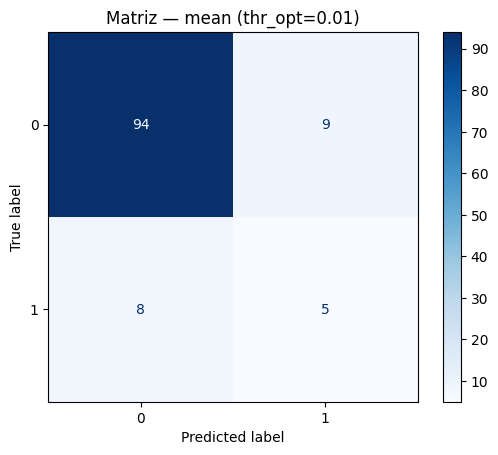

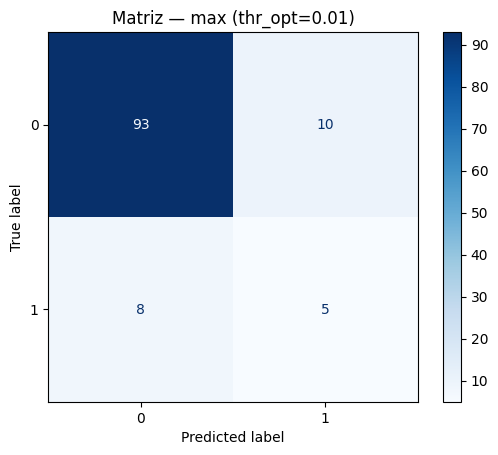

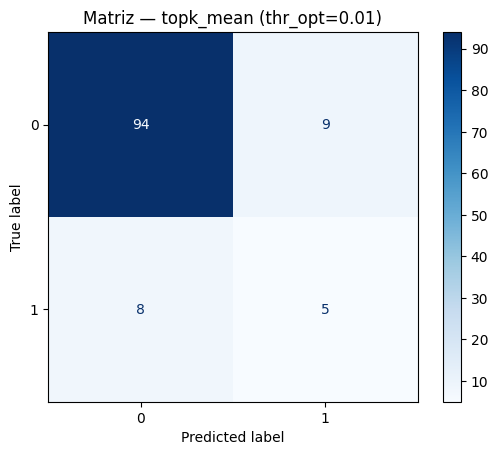

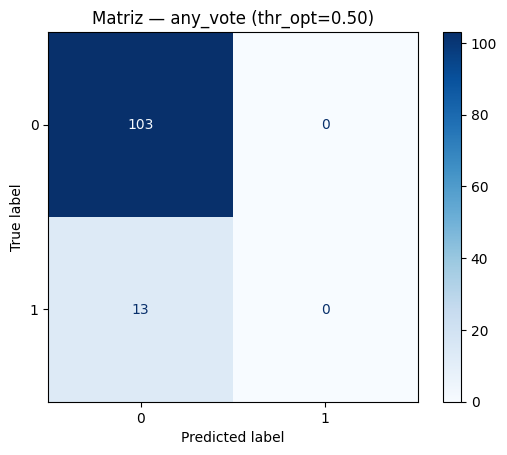

,estrategia,thr_opt,acc,prec,rec,f1
0,mean,0.006183,0.853448,0.357143,0.384615,0.370370
2,topk_mean,0.006183,0.853448,0.357143,0.384615,0.370370
1,max,0.006514,0.844828,0.333333,0.384615,0.357143
3,any_vote,0.500000,0.887931,0.000000,0.000000,0.000000


In [11]:
# ============================================================
# Clasificación por CHUNK + agregación a nivel llamada
# Texto  : "transcripción" (cambia si es "transcripcion")
# Target : "2.2 Alternativas de acuerdo a la necesidad" (0/1)
# ============================================================
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve)

# ---------------- Config ----------------
TEXT   = "transcripcion"   # o "transcripcion"
TARGET = "2.2 Alternativas de acuerdo a la necesidad"
TEST_SIZE = 0.2
SEED = 42

EMB_MODEL = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
CHUNK_TOKENS = 480
CHUNK_STRIDE = 64

CLASSIFIER = "lgbm"   # "lgbm" o "logreg"
USE_ROS = False       # oversampling a nivel chunk

# Estrategias de agregación para comparar
AGG_STRATEGIES = [
    ("mean", {"k": None, "chunk_thr": 0.5}),
    ("max",  {"k": None, "chunk_thr": 0.5}),
    ("topk_mean", {"k": 3, "chunk_thr": 0.5}),   # promedio de los k chunks con mayor prob
    ("any_vote", {"k": None, "chunk_thr": 0.5}), # positivo si algún chunk >= chunk_thr
]

# ---------------- Helpers mínimos ----------------
def clean(t): return re.sub(r"\s+"," ", str(t).strip())

def best_thr_f1_pos(y_true, p_pos):
    y_bin = (y_true==1).astype(int)
    prec, rec, thr = precision_recall_curve(y_bin, p_pos)
    f1 = (2*prec[:-1]*rec[:-1])/(prec[:-1]+rec[:-1]+1e-12)
    k = f1.argmax()
    return float(thr[k]), float(f1[k])

# ---------------- Datos ----------------
assert TARGET in df.columns and TEXT in df.columns, "Revisa nombres de columnas."
data = df[[TEXT, TARGET]].dropna().copy()
data[TEXT] = data[TEXT].map(clean)
data[TARGET] = data[TARGET].astype(int)

train_df, test_df = train_test_split(data, test_size=TEST_SIZE, random_state=SEED, stratify=data[TARGET])
y_te_call = test_df[TARGET].values
print("Distribución train:", train_df[TARGET].value_counts().sort_index().to_dict())
print("Distribución test :", test_df[TARGET].value_counts().sort_index().to_dict())

# ---------------- Embeddings por CHUNK (ultra-seguro) ----------------
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
embedder = SentenceTransformer(EMB_MODEL); embedder.max_seq_length = 510
tok = AutoTokenizer.from_pretrained(EMB_MODEL)

def call_to_safe_chunks(text, max_len=CHUNK_TOKENS, stride=CHUNK_STRIDE):
    ids = tok(text, add_special_tokens=False, truncation=False)["input_ids"]
    if isinstance(ids[0], list): ids = ids[0]
    chunks, i = [], 0
    while i < len(ids):
        j = min(i + max_len, len(ids))
        raw_txt = tok.decode(ids[i:j], skip_special_tokens=True, clean_up_tokenization_spaces=True)
        t2 = tok(raw_txt, add_special_tokens=True, truncation=True, max_length=510)
        safe_txt = tok.decode(t2["input_ids"], skip_special_tokens=True, clean_up_tokenization_spaces=True)
        if safe_txt.strip(): chunks.append(safe_txt)
        if j == len(ids): break
        i = max(j - stride, 0)
    return chunks if chunks else [text]

def embed_chunks(texts_list):
    # texts_list: lista de strings (chunks)
    return embedder.encode(texts_list, normalize_embeddings=True, batch_size=64, show_progress_bar=False)

# Expandir train/test a nivel chunk
def expand_to_chunks(df_subset):
    rows = []
    for idx, r in df_subset.iterrows():
        chs = call_to_safe_chunks(r[TEXT])
        for c in chs:
            rows.append({"call_id": idx, "chunk_text": c, "label": int(r[TARGET])})
    return pd.DataFrame(rows)

train_chunks = expand_to_chunks(train_df)
test_chunks  = expand_to_chunks(test_df)

# Embeddings por chunk
E_train = embed_chunks(train_chunks["chunk_text"].tolist())
E_test  = embed_chunks(test_chunks["chunk_text"].tolist())

# ---------------- Clasificador a nivel chunk ----------------
Xtr, ytr = E_train, train_chunks["label"].values
Xte, yte = E_test,  test_chunks["label"].values

if USE_ROS:
    from imblearn.over_sampling import RandomOverSampler
    ros = RandomOverSampler(random_state=SEED)
    Xtr, ytr = ros.fit_resample(Xtr, ytr)

if CLASSIFIER == "lgbm":
    import lightgbm as lgb
    n_pos = (ytr==1).sum(); n_neg = len(ytr)-n_pos
    spw = max(n_neg / max(n_pos,1), 1.0)
    clf = lgb.LGBMClassifier(
        n_estimators=700, learning_rate=0.05, num_leaves=63,
        subsample=0.9, colsample_bytree=0.9, random_state=SEED,
        objective="binary", scale_pos_weight=spw
    )
    clf.fit(Xtr, ytr)
    p_chunk = clf.predict_proba(Xte)[:,1]
elif CLASSIFIER == "logreg":
    from sklearn.linear_model import LogisticRegression
    cw = "balanced" if not USE_ROS else None
    clf = LogisticRegression(max_iter=2000, solver="lbfgs", class_weight=cw)
    clf.fit(Xtr, ytr)
    p_chunk = clf.predict_proba(Xte)[:,1]
else:
    raise ValueError("CLASSIFIER debe ser 'lgbm' o 'logreg'.")

# ---------------- Agregación por llamada ----------------
# Mapeo de probabilidades por call_id
test_chunks = test_chunks.reset_index(drop=True)
test_chunks["p1"] = p_chunk

# Agrupar por llamada y aplicar estrategias
resultados = []
for name, cfg in AGG_STRATEGIES:
    k = cfg.get("k", None)
    chunk_thr = cfg.get("chunk_thr", 0.5)

    agg_probs = []
    for call_id, grp in test_chunks.groupby("call_id"):
        probs = grp["p1"].values
        if name == "mean":
            agg = float(np.mean(probs))
        elif name == "max":
            agg = float(np.max(probs))
        elif name == "topk_mean":
            kk = min(k or 1, len(probs))
            agg = float(np.mean(np.sort(probs)[-kk:]))
        elif name == "any_vote":
            agg = float(1.0 if (probs >= chunk_thr).any() else 0.0)  # prob “dura”; dejar como 0/1
        else:
            raise ValueError(name)
        agg_probs.append((call_id, agg))

    agg_probs = pd.DataFrame(agg_probs, columns=["call_id","p_call"])

    # y_true por llamada
    y_true_call = test_df.loc[agg_probs["call_id"].values, TARGET].values

    # Si any_vote produjo 0/1 "duros", usa directamente; si no, optimiza umbral
    if name == "any_vote":
        yhat = agg_probs["p_call"].values.astype(int)
        p_call_for_thr = agg_probs["p_call"].values  # 0/1
        thr_opt = 0.5
    else:
        p_call_for_thr = agg_probs["p_call"].values
        thr_opt, _ = best_thr_f1_pos(y_true_call, p_call_for_thr)
        yhat = (p_call_for_thr >= thr_opt).astype(int)

    acc  = accuracy_score(y_true_call, yhat)
    prec = precision_score(y_true_call, yhat, zero_division=0)
    rec  = recall_score(y_true_call, yhat, zero_division=0)
    f1   = f1_score(y_true_call, yhat, zero_division=0)

    resultados.append({
        "estrategia": name, "thr_opt": thr_opt,
        "acc": acc, "prec": prec, "rec": rec, "f1": f1
    })

    # Matriz de confusión
    cm = confusion_matrix(y_true_call, yhat)
    ConfusionMatrixDisplay(cm).plot(cmap="Blues", values_format="d")
    plt.title(f"Matriz — {name} (thr_opt={thr_opt:.2f})")
    plt.show()

# ---------------- Resumen comparativo ----------------
df_comp = pd.DataFrame(resultados).sort_values(["rec","f1"], ascending=False)
display(df_comp)

Distribución train: {0: 411, 1: 53}
Distribución test : {0: 103, 1: 13}


Token indices sequence length is longer than the specified maximum sequence length for this model (686 > 512). Running this sequence through the model will result in indexing errors


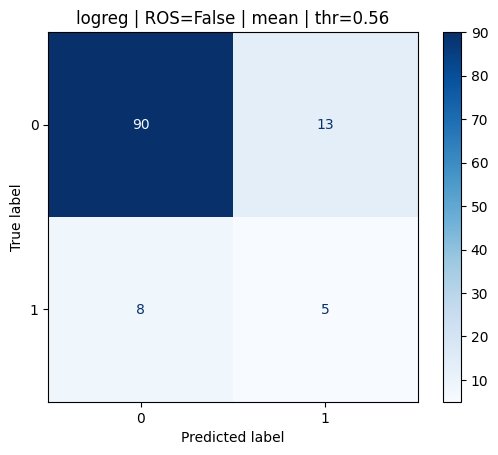

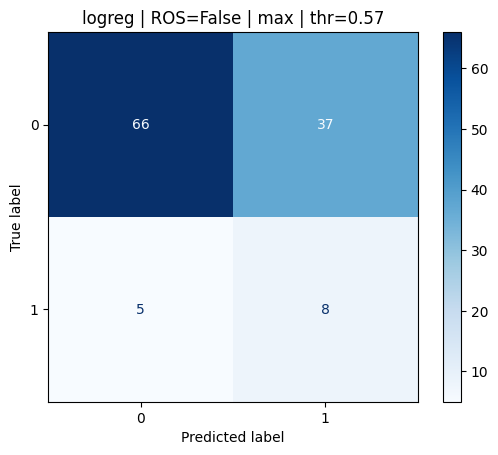

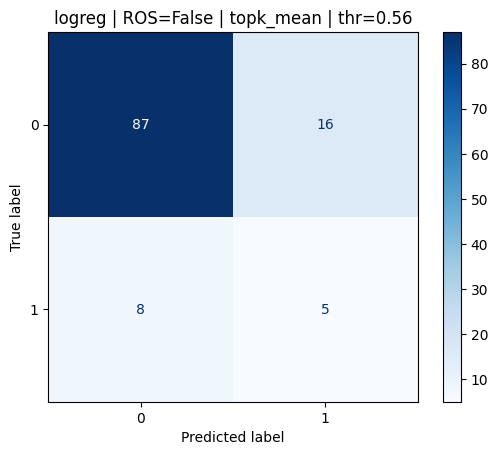

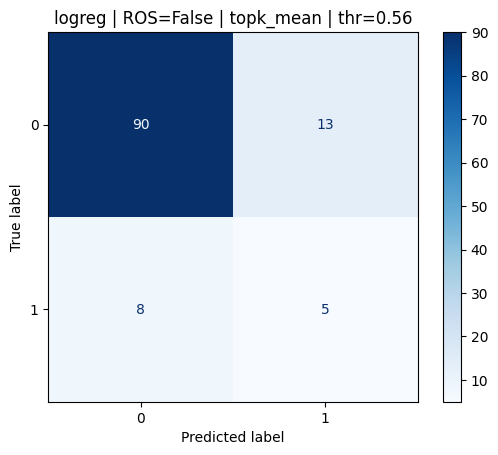

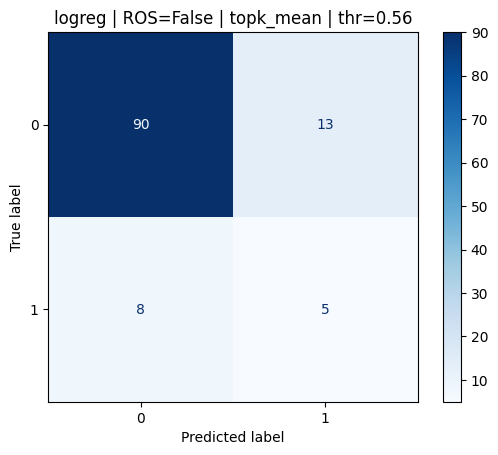

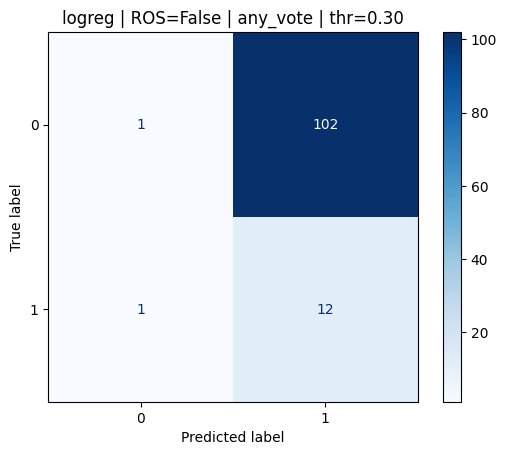

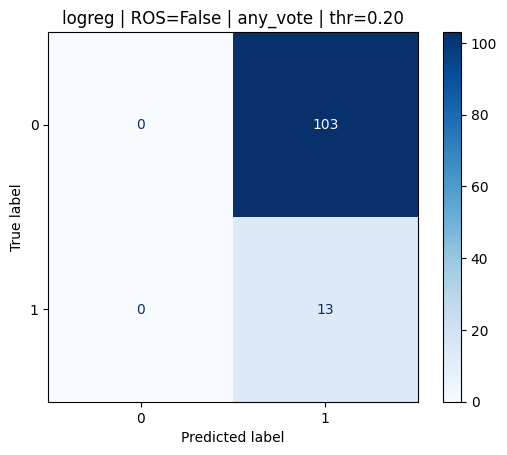

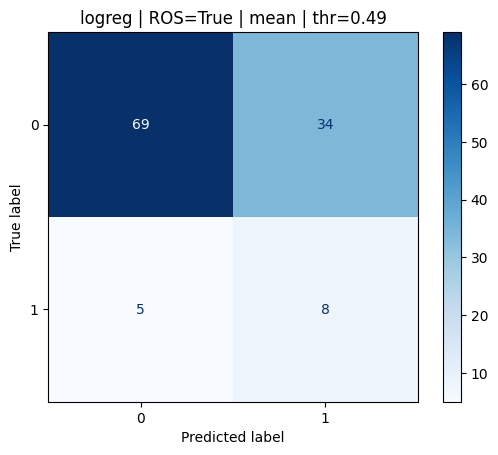

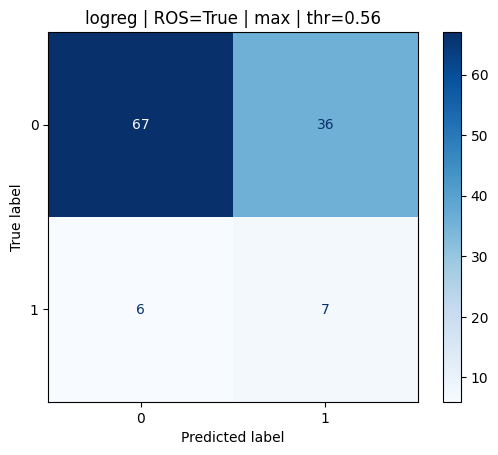

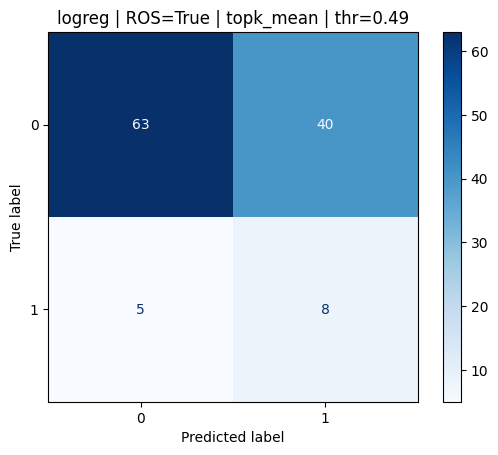

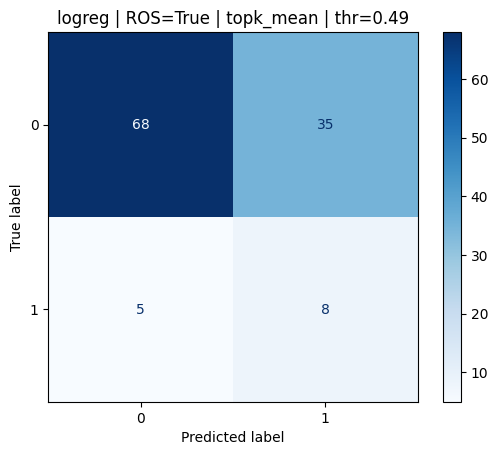

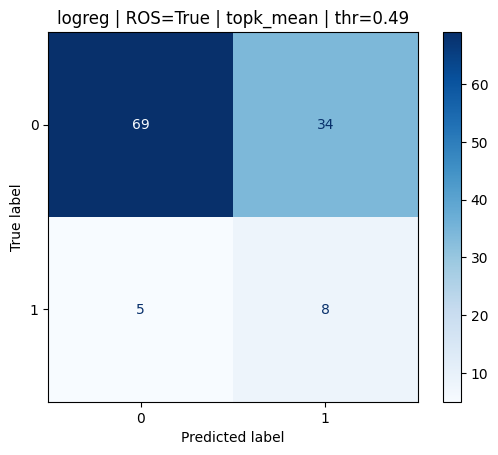

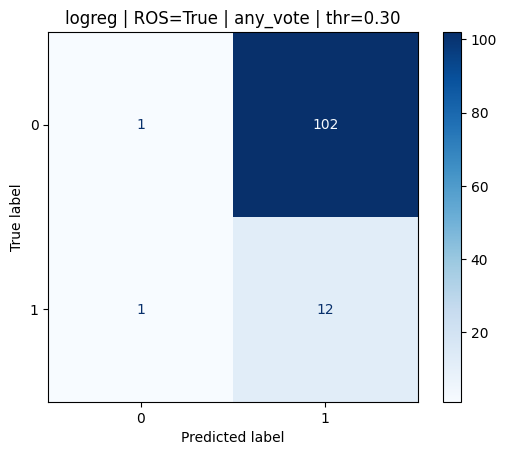

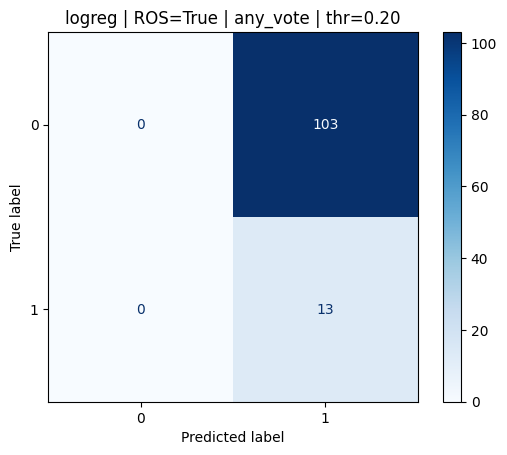

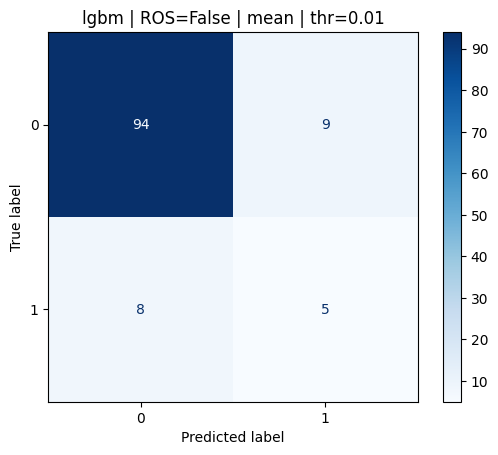

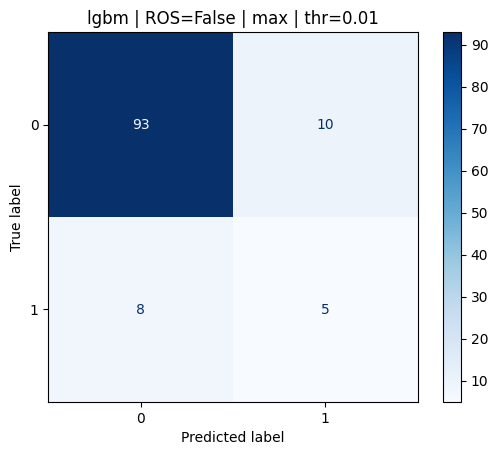

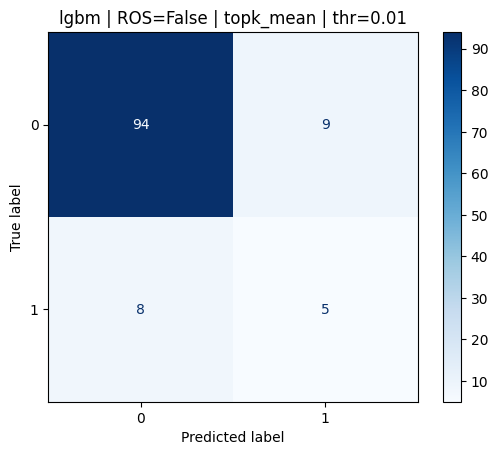

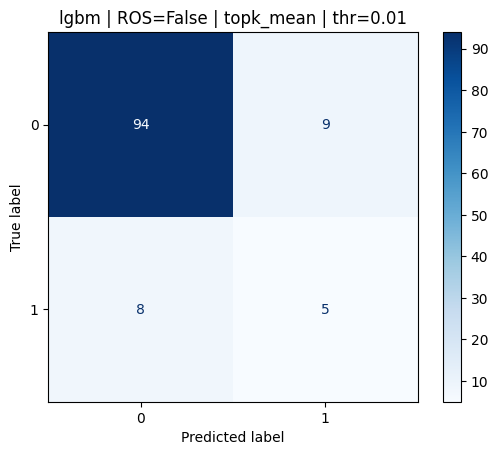

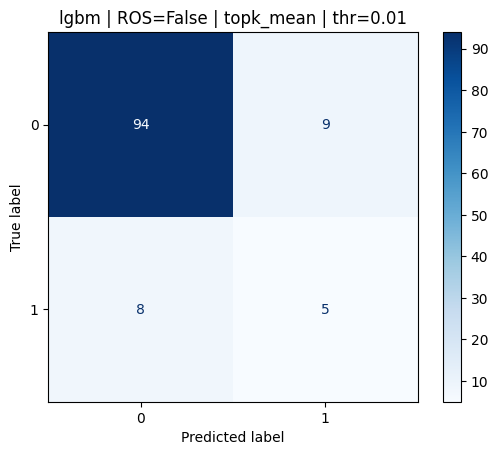

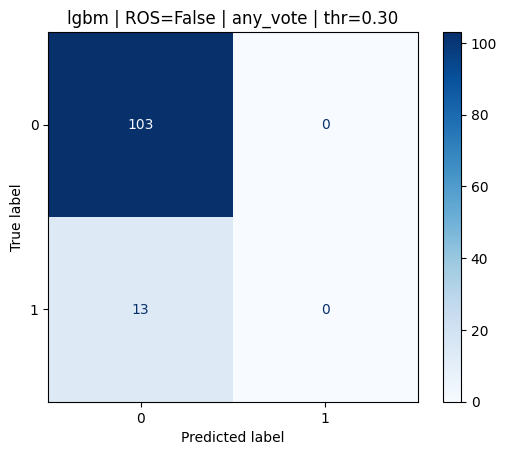

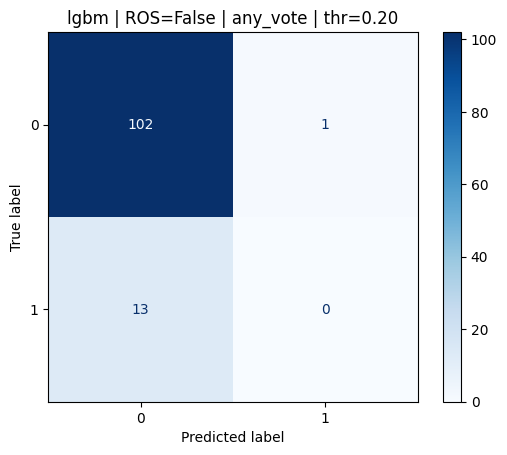

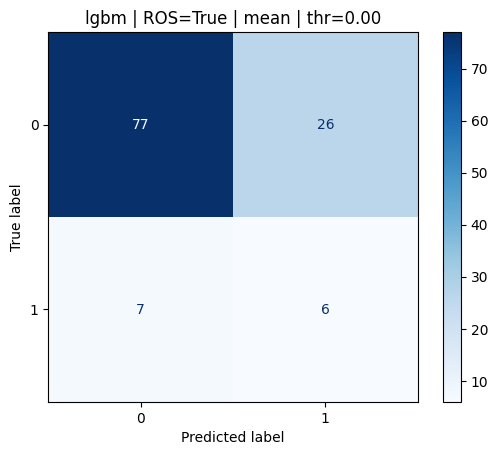

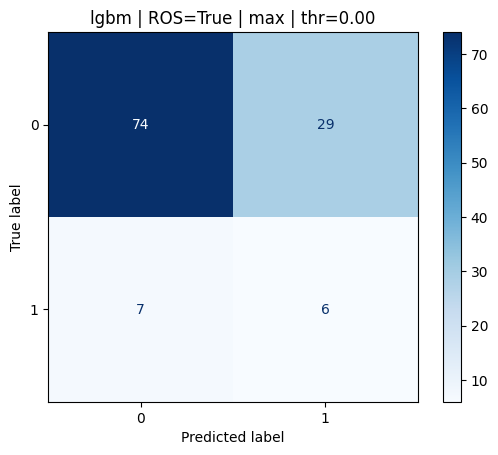

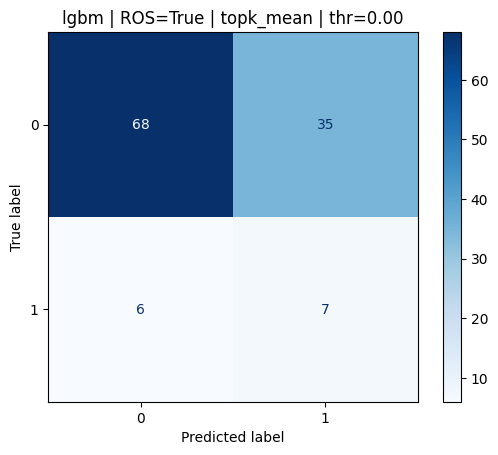

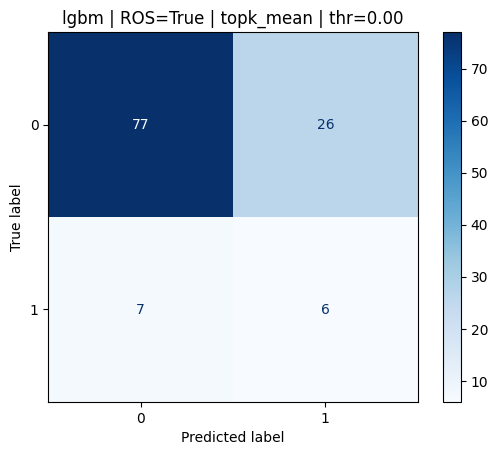

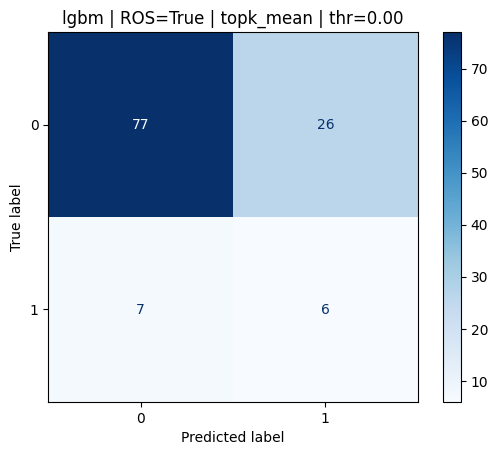

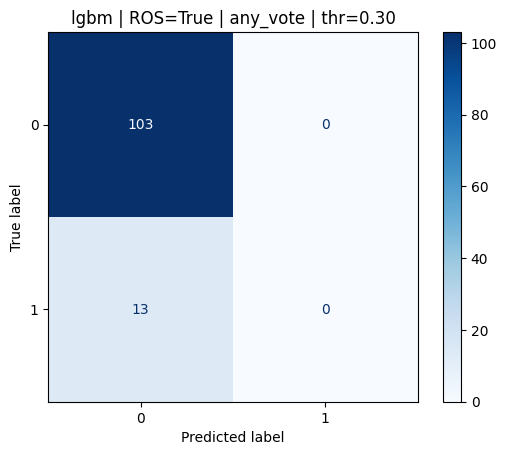

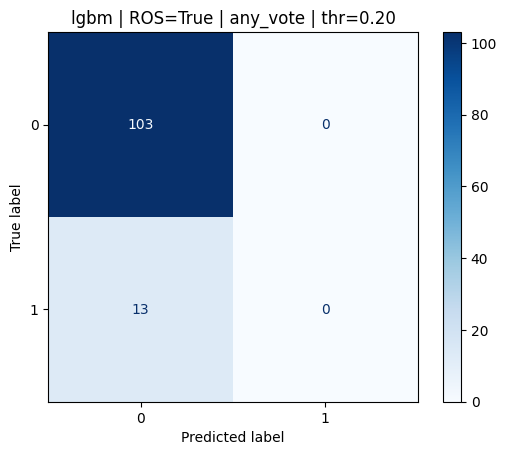

,modelo,ros,estrategia,thr_opt,acc,prec,rec,f1
6,logreg,False,any_vote,0.200000,0.112069,0.112069,1.000000,0.201550
13,logreg,True,any_vote,0.200000,0.112069,0.112069,1.000000,0.201550
5,logreg,False,any_vote,0.300000,0.112069,0.105263,0.923077,0.188976
12,logreg,True,any_vote,0.300000,0.112069,0.105263,0.923077,0.188976
7,logreg,True,mean,0.492891,0.663793,0.190476,0.615385,0.290909
11,logreg,True,topk_mean(k=10),0.492891,0.663793,0.190476,0.615385,0.290909
10,logreg,True,topk_mean(k=5),0.492891,0.655172,0.186047,0.615385,0.285714
1,logreg,False,max,0.565391,0.637931,0.177778,0.615385,0.275862
9,logreg,True,topk_mean(k=3),0.494330,0.612069,0.166667,0.615385,0.262295
23,lgbm,True,topk_mean(k=3),0.000486,0.646552,0.166667,0.538462,0.254545



Top por estrategia:


,modelo,ros,estrategia,thr_opt,acc,prec,rec,f1
6,logreg,False,any_vote,0.200000,0.112069,0.112069,1.000000,0.201550
13,logreg,True,any_vote,0.200000,0.112069,0.112069,1.000000,0.201550
5,logreg,False,any_vote,0.300000,0.112069,0.105263,0.923077,0.188976
1,logreg,False,max,0.565391,0.637931,0.177778,0.615385,0.275862
8,logreg,True,max,0.561404,0.637931,0.162791,0.538462,0.250000
22,lgbm,True,max,0.000957,0.689655,0.171429,0.461538,0.250000
7,logreg,True,mean,0.492891,0.663793,0.190476,0.615385,0.290909
21,lgbm,True,mean,0.000603,0.715517,0.187500,0.461538,0.266667
14,lgbm,False,mean,0.006183,0.853448,0.357143,0.384615,0.370370
11,logreg,True,topk_mean(k=10),0.492891,0.663793,0.190476,0.615385,0.290909



Top-10 global por recall y F1:


,modelo,ros,estrategia,thr_opt,acc,prec,rec,f1
6,logreg,False,any_vote,0.200000,0.112069,0.112069,1.000000,0.201550
13,logreg,True,any_vote,0.200000,0.112069,0.112069,1.000000,0.201550
5,logreg,False,any_vote,0.300000,0.112069,0.105263,0.923077,0.188976
12,logreg,True,any_vote,0.300000,0.112069,0.105263,0.923077,0.188976
7,logreg,True,mean,0.492891,0.663793,0.190476,0.615385,0.290909
11,logreg,True,topk_mean(k=10),0.492891,0.663793,0.190476,0.615385,0.290909
10,logreg,True,topk_mean(k=5),0.492891,0.655172,0.186047,0.615385,0.285714
1,logreg,False,max,0.565391,0.637931,0.177778,0.615385,0.275862
9,logreg,True,topk_mean(k=3),0.494330,0.612069,0.166667,0.615385,0.262295
23,lgbm,True,topk_mean(k=3),0.000486,0.646552,0.166667,0.538462,0.254545


In [12]:
# ============================================================
# Comparativo masivo: (LogReg vs LightGBM) × (ROS/no ROS) × agregaciones
# Texto  : "transcripción"  (cambia a "transcripcion" si aplica)
# Target : "2.2 Alternativas de acuerdo a la necesidad" (0/1)
# ============================================================
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve)

# ---------------- Config ----------------
TEXT   = "transcripcion"   # o "transcripcion"
TARGET = "2.2 Alternativas de acuerdo a la necesidad"
TEST_SIZE = 0.2
SEED = 42

EMB_MODEL = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
CHUNK_TOKENS = 480
CHUNK_STRIDE = 64

CLASSIFIERS = ["logreg", "lgbm"]   # probamos ambos
ROS_OPTIONS = [False, True]        # sin ROS y con ROS a nivel chunk

# Agregaciones a evaluar (se expanden k y thr abajo)
AGG_BASE = [
    ("mean",      {"k": None, "chunk_thr": None}),
    ("max",       {"k": None, "chunk_thr": None}),
    ("topk_mean", {"k": 3,    "chunk_thr": None}),
    ("topk_mean", {"k": 5,    "chunk_thr": None}),
    ("topk_mean", {"k": 10,   "chunk_thr": None}),
    ("any_vote",  {"k": None, "chunk_thr": 0.30}),
    ("any_vote",  {"k": None, "chunk_thr": 0.20}),
]

# ---------------- Helpers mínimos ----------------
def clean(t): return re.sub(r"\s+"," ", str(t).strip())

def best_thr_f1_pos(y_true, p_pos):
    y_bin = (y_true==1).astype(int)
    prec, rec, thr = precision_recall_curve(y_bin, p_pos)
    f1 = (2*prec[:-1]*rec[:-1])/(prec[:-1]+rec[:-1]+1e-12)
    if len(f1)==0: return 0.5, 0.0
    k = f1.argmax()
    return float(thr[k]), float(f1[k])

# ---------------- Datos ----------------
assert TARGET in df.columns and TEXT in df.columns, "Revisa nombres de columnas."
data = df[[TEXT, TARGET]].dropna().copy()
data[TEXT] = data[TEXT].map(clean)
data[TARGET] = data[TARGET].astype(int)

train_df, test_df = train_test_split(data, test_size=TEST_SIZE, random_state=SEED, stratify=data[TARGET])
y_te_call = test_df[TARGET].values
print("Distribución train:", train_df[TARGET].value_counts().sort_index().to_dict())
print("Distribución test :", test_df[TARGET].value_counts().sort_index().to_dict())

# ---------------- Embeddings por CHUNK (ultra-seguro) ----------------
import os, warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"
warnings.filterwarnings("ignore")

from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
embedder = SentenceTransformer(EMB_MODEL); embedder.max_seq_length = 510
tok = AutoTokenizer.from_pretrained(EMB_MODEL)

def call_to_safe_chunks(text, max_len=CHUNK_TOKENS, stride=CHUNK_STRIDE):
    ids = tok(text, add_special_tokens=False, truncation=False)["input_ids"]
    if isinstance(ids[0], list): ids = ids[0]
    chunks, i = [], 0
    while i < len(ids):
        j = min(i + max_len, len(ids))
        raw_txt = tok.decode(ids[i:j], skip_special_tokens=True, clean_up_tokenization_spaces=True)
        t2 = tok(raw_txt, add_special_tokens=True, truncation=True, max_length=510)
        safe_txt = tok.decode(t2["input_ids"], skip_special_tokens=True, clean_up_tokenization_spaces=True)
        if safe_txt.strip(): chunks.append(safe_txt)
        if j == len(ids): break
        i = max(j - stride, 0)
    return chunks if chunks else [text]

def embed_chunks(texts_list):
    return embedder.encode(texts_list, normalize_embeddings=True, batch_size=64, show_progress_bar=False)

def expand_to_chunks(df_subset):
    rows = []
    for idx, r in df_subset.iterrows():
        chs = call_to_safe_chunks(r[TEXT])
        for c in chs:
            rows.append({"call_id": idx, "chunk_text": c, "label": int(r[TARGET])})
    return pd.DataFrame(rows)

# Expandir train/test a nivel chunk y embeber
train_chunks = expand_to_chunks(train_df)
test_chunks  = expand_to_chunks(test_df)
E_train = embed_chunks(train_chunks["chunk_text"].tolist())
E_test  = embed_chunks(test_chunks["chunk_text"].tolist())

Xtr_all, ytr_all = E_train, train_chunks["label"].values
Xte_all, yte_all = E_test,  test_chunks["label"].values
test_chunks = test_chunks.reset_index(drop=True)

# ---------------- Experimentos ----------------
from imblearn.over_sampling import RandomOverSampler
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression

def fit_predict_chunk_classifier(model_name, use_ros, Xtr, ytr, Xte):
    if use_ros:
        ros = RandomOverSampler(random_state=SEED)
        Xtr, ytr = ros.fit_resample(Xtr, ytr)
        class_weight = None
    else:
        class_weight = "balanced" if model_name=="logreg" else None

    if model_name == "logreg":
        clf = LogisticRegression(max_iter=3000, solver="lbfgs", class_weight=class_weight)
        clf.fit(Xtr, ytr)
        p_chunk = clf.predict_proba(Xte)[:,1]
    elif model_name == "lgbm":
        n_pos = (ytr==1).sum(); n_neg = len(ytr)-n_pos
        spw = max(n_neg / max(n_pos,1), 1.0)
        clf = lgb.LGBMClassifier(
            n_estimators=700, learning_rate=0.05, num_leaves=63,
            subsample=0.9, colsample_bytree=0.9, random_state=SEED,
            objective="binary", scale_pos_weight=spw, verbose=-1
        )
        clf.fit(Xtr, ytr)
        p_chunk = clf.predict_proba(Xte)[:,1]
    else:
        raise ValueError("model_name debe ser 'logreg' o 'lgbm'")
    return p_chunk

def aggregate_per_call(p_chunk, strategy, cfg):
    df_tmp = test_chunks.copy()
    df_tmp["p1"] = p_chunk
    agg_probs = []
    for call_id, grp in df_tmp.groupby("call_id"):
        probs = grp["p1"].values
        if strategy == "mean":
            agg = float(np.mean(probs))
        elif strategy == "max":
            agg = float(np.max(probs))
        elif strategy == "topk_mean":
            k = min(int(cfg["k"]), len(probs))
            agg = float(np.mean(np.sort(probs)[-k:]))
        elif strategy == "any_vote":
            thr = float(cfg["chunk_thr"])
            agg = float(1.0 if (probs >= thr).any() else 0.0)
        else:
            raise ValueError(strategy)
        agg_probs.append((call_id, agg))
    agg_probs = pd.DataFrame(agg_probs, columns=["call_id","p_call"])
    y_true_call = test_df.loc[agg_probs["call_id"].values, TARGET].values
    return agg_probs, y_true_call

# Corre todas las combinaciones
res = []
for model_name in CLASSIFIERS:
    for use_ros in ROS_OPTIONS:
        p_chunk = fit_predict_chunk_classifier(model_name, use_ros, Xtr_all, ytr_all, Xte_all)
        for strat, cfg in AGG_BASE:
            agg_probs, y_true_call = aggregate_per_call(p_chunk, strat, cfg)

            # Si es any_vote (0/1 duros)
            if strat == "any_vote":
                yhat = agg_probs["p_call"].values.astype(int)
                thr_opt = cfg["chunk_thr"]
            else:
                p_call = agg_probs["p_call"].values
                thr_opt, _ = best_thr_f1_pos(y_true_call, p_call)
                yhat = (p_call >= thr_opt).astype(int)

            acc  = accuracy_score(y_true_call, yhat)
            prec = precision_score(y_true_call, yhat, zero_division=0)
            rec  = recall_score(y_true_call, yhat, zero_division=0)
            f1   = f1_score(y_true_call, yhat, zero_division=0)

            res.append({
                "modelo": model_name,
                "ros": use_ros,
                "estrategia": f"{strat}" if cfg["k"] is None else f"{strat}(k={cfg['k']})",
                "thr_opt": float(thr_opt),
                "acc": acc, "prec": prec, "rec": rec, "f1": f1
            })

            # Matriz (opcional): comenta las 4 líneas si no quieres muchos plots
            cm = confusion_matrix(y_true_call, yhat)
            ConfusionMatrixDisplay(cm).plot(cmap="Blues", values_format="d")
            plt.title(f"{model_name} | ROS={use_ros} | {strat} | thr={thr_opt:.2f}")
            plt.show()

# Resumen
df_all = pd.DataFrame(res).sort_values(["rec","f1"], ascending=False)
display(df_all)

# Vista rápida: mejor por estrategia (independiente del modelo)
print("\nTop por estrategia:")
display(df_all.sort_values(["estrategia","rec","f1"], ascending=[True,False,False]).groupby("estrategia").head(3))

# Vista rápida: top-10 global
print("\nTop-10 global por recall y F1:")
display(df_all.head(10))

In [13]:
# ============================
# ENTRENAMIENTO LoRA por épocas (compat sin evaluation_strategy)
# ============================
import os, re, warnings, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split

# 🚫 Desactivar wandb y verbosidad
os.environ["WANDB_DISABLED"] = "true"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
warnings.filterwarnings("ignore")

# ---- Config ----
BASE_MODEL = "BSC-LT/roberta-base-bne"   # modelo español con tokenizer completo
TEXT_COL   = "transcripcion"             # o "transcripcion"
TARGET_COL = "2.2 Alternativas de acuerdo a la necesidad"
SEED = 42
CHUNK_TOKENS = 480
CHUNK_STRIDE = 64
EPOCHS = 8
LR = 2e-5
BATCH = 8
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.1

# ---- Datos ----
def clean(t): return re.sub(r"\s+"," ", str(t).strip())
assert TEXT_COL in df.columns and TARGET_COL in df.columns
df0 = df[[TEXT_COL, TARGET_COL]].dropna().copy()
df0[TEXT_COL] = df0[TEXT_COL].map(clean)
df0[TARGET_COL] = df0[TARGET_COL].astype(int)

train_calls, test_calls = train_test_split(df0, test_size=0.2, random_state=SEED, stratify=df0[TARGET_COL])
train_calls, val_calls  = train_test_split(train_calls, test_size=0.2, random_state=SEED, stratify=train_calls[TARGET_COL])

# ---- Tokenizer (fast) ----
from transformers import AutoTokenizer
tok = AutoTokenizer.from_pretrained(BASE_MODEL, use_fast=True)
if tok.pad_token is None:
    tok.add_special_tokens({"pad_token": "[PAD]"})
tok.model_max_length = 512

# ---- Chunking seguro ----
def call_to_safe_chunks(text, max_len=CHUNK_TOKENS, stride=CHUNK_STRIDE):
    ids = tok(text, add_special_tokens=False, truncation=False)["input_ids"]
    chunks, i = [], 0
    while i < len(ids):
        j = min(i + max_len, len(ids))
        raw_txt = tok.decode(ids[i:j], skip_special_tokens=True, clean_up_tokenization_spaces=True)
        t2 = tok(raw_txt, add_special_tokens=True, truncation=True, max_length=510)
        safe_txt = tok.decode(t2["input_ids"], skip_special_tokens=True, clean_up_tokenization_spaces=True)
        if safe_txt.strip(): chunks.append(safe_txt)
        if j == len(ids): break
        i = max(j - stride, 0)
    return chunks or [text]

def expand_df(df_calls):
    rows = []
    for i, r in df_calls.reset_index(drop=True).iterrows():
        for c in call_to_safe_chunks(r[TEXT_COL]):
            rows.append({"call_id": i, "text": c, "label": int(r[TARGET_COL])})
    return pd.DataFrame(rows)

df_tr = expand_df(train_calls)
df_val = expand_df(val_calls)
df_te = expand_df(test_calls)

# ---- HF datasets ----
from datasets import Dataset
def encode_batch(batch):
    return tok(batch["text"], truncation=True, max_length=512)

ds_tr  = Dataset.from_pandas(df_tr[["text","label"]].rename(columns={"label":"labels"})).map(encode_batch, batched=True, remove_columns=["text"])
ds_val = Dataset.from_pandas(df_val[["text","label"]].rename(columns={"label":"labels"})).map(encode_batch, batched=True, remove_columns=["text"])
ds_te  = Dataset.from_pandas(df_te[["call_id","text","label"]].rename(columns={"label":"labels"})).map(encode_batch, batched=True, remove_columns=["text"])

# ---- Modelo + LoRA ----
import torch
from transformers import AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, TaskType

base = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=2)
lora_cfg = LoraConfig(task_type=TaskType.SEQ_CLS, r=8, lora_alpha=16, lora_dropout=0.05,
                      target_modules=["query","key","value","dense"])
model = get_peft_model(base, lora_cfg)
data_collator = DataCollatorWithPadding(tokenizer=tok)

# ---- Métricas ----
from sklearn.metrics import f1_score, accuracy_score
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = (logits[:,1] >= logits[:,0]).astype(int)
    return {"eval_f1_pos": f1_score(labels, preds, pos_label=1, zero_division=0),
            "eval_acc": accuracy_score(labels, preds)}

# ---------- Entrenamiento MANUAL por época (compatible sin evaluation_strategy) ----------
hist = []                      # guardamos métricas por época
best_f1 = -1.0
best_dir = "salida_modelo/lora_roberta_bne_best"
os.makedirs(best_dir, exist_ok=True)

for ep in range(1, EPOCHS+1):
    # TrainingArguments para UNA época
    args = TrainingArguments(
        output_dir=f"salida_modelo/lora_roberta_bne/run_ep{ep}",
        learning_rate=LR,
        per_device_train_batch_size=BATCH,
        per_device_eval_batch_size=BATCH,
        num_train_epochs=1,           # <<< entrenar 1 época
        weight_decay=WEIGHT_DECAY,
        warmup_ratio=WARMUP_RATIO,
        seed=SEED,
        logging_steps=50,
        do_eval=True,                 # <<< permitir evaluate()
        save_strategy="no",           # guardamos manualmente el "best"
        logging_strategy="steps"
    )
    trainer = Trainer(
        model=model, args=args,
        train_dataset=ds_tr, eval_dataset=ds_val,
        tokenizer=tok, data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    train_out = trainer.train()                       # entrena 1 época
    eval_out  = trainer.evaluate(eval_dataset=ds_val) # evalúa validación

    # Registrar historial
    hist.append({
        "epoch": ep,
        "train_loss": float(getattr(train_out, "training_loss", np.nan)),
        "eval_loss": float(eval_out.get("eval_loss", np.nan)),
        "eval_f1_pos": float(eval_out.get("eval_f1_pos", np.nan)),
        "eval_acc": float(eval_out.get("eval_acc", np.nan)),
    })

    # Guardar mejor por F1
    f1 = eval_out.get("eval_f1_pos", -1.0)
    if f1 is not None and f1 > best_f1:
        best_f1 = f1
        trainer.model.save_pretrained(best_dir)     # guarda adaptadores LoRA
        tok.save_pretrained(best_dir)
        print(f"✅ Nuevo mejor modelo en epoch {ep} — eval_f1_pos={best_f1:.4f}")

# Guardar el último y el historial
final_dir = "salida_modelo/lora_roberta_bne_last"
os.makedirs(final_dir, exist_ok=True)
trainer.model.save_pretrained(final_dir)
tok.save_pretrained(final_dir)
pd.DataFrame(hist).to_csv("salida_modelo/hist_epocas.csv", index=False)

print("✅ Entrenamiento terminado. Mejor F1:", best_f1)

OSError: BSC-LT/roberta-base-bne is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `hf auth login` or by passing `token=<your_token>`

In [ ]:
import pandas as pd, matplotlib.pyplot as plt
hist = pd.read_csv("salida_modelo/hist_epocas.csv")

print(hist)

plt.figure(figsize=(7,4))
plt.plot(hist["epoch"], hist["train_loss"], marker="o", label="train loss")
if "eval_loss" in hist:
    plt.plot(hist["epoch"], hist["eval_loss"], marker="o", label="eval loss")
plt.xlabel("Época"); plt.ylabel("Loss"); plt.title("Curva de pérdida"); plt.grid(True, alpha=0.3); plt.legend(); plt.show()

plt.figure(figsize=(7,4))
if "eval_f1_pos" in hist:
    plt.plot(hist["epoch"], hist["eval_f1_pos"], marker="o", label="eval F1_pos")
if "eval_acc" in hist:
    plt.plot(hist["epoch"], hist["eval_acc"], marker="o", label="eval acc")
plt.xlabel("Época"); plt.ylabel("Métrica"); plt.title("Métricas de validación"); plt.grid(True, alpha=0.3); plt.legend(); plt.show()


In [ ]:
# ============================
# Curvas de entrenamiento (loss) y validación (F1/acc) por época
# Usa trainer.state.log_history
# ============================
import pandas as pd, numpy as np, matplotlib.pyplot as plt

# 1) Extraer log_history del Trainer
log = pd.DataFrame(trainer.state.log_history)
if log.empty:
    raise RuntimeError("No hay log_history en el Trainer. Asegúrate de haber corrido la Celda A con evaluación por época.")

# 2) Separar vistas convenientes
train_steps = log.loc[log["loss"].notna(), ["epoch", "loss"]].copy()
eval_epochs = log.loc[log["eval_loss"].notna(), ["epoch", "eval_loss", "eval_f1_pos", "eval_acc"]].copy() if "eval_loss" in log else pd.DataFrame()

# Si la versión antigua no guardó eval_* por época, avisar
if eval_epochs.empty:
    print("⚠️ No se encontraron métricas de validación (eval_*) en el log.")
    print("   Repite el entrenamiento con evaluación por época (evaluation_strategy='epoch').")
else:
    # 3) Mejor época por F1 y por eval_loss
    best_f1_row = eval_epochs.loc[eval_epochs["eval_f1_pos"].idxmax()]
    best_loss_row = eval_epochs.loc[eval_epochs["eval_loss"].idxmin()]
    print(f"Mejor época por F1_pos: epoch={best_f1_row['epoch']:.2f}  F1_pos={best_f1_row['eval_f1_pos']:.4f}  Acc={best_f1_row.get('eval_acc', np.nan):.4f}  EvalLoss={best_f1_row['eval_loss']:.4f}")
    print(f"Mejor época por EvalLoss: epoch={best_loss_row['epoch']:.2f}  EvalLoss={best_loss_row['eval_loss']:.4f}  F1_pos={best_loss_row.get('eval_f1_pos', np.nan):.4f}")

# 4) Gráfico de pérdidas (train vs eval)
plt.figure(figsize=(7,4))
if not train_steps.empty:
    # Promediar por época por si hay múltiples logs dentro de la misma
    tr = train_steps.groupby(train_steps["epoch"].round(2))["loss"].mean()
    plt.plot(tr.index, tr.values, marker="o", label="train loss")
if not eval_epochs.empty:
    ev = eval_epochs.groupby(eval_epochs["epoch"].round(2))["eval_loss"].mean()
    plt.plot(ev.index, ev.values, marker="o", label="eval loss")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Curva de pérdida")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 5) Gráfico de métricas de validación (F1_pos y accuracy)
if not eval_epochs.empty:
    plt.figure(figsize=(7,4))
    ev_f1 = eval_epochs.groupby(eval_epochs["epoch"].round(2))["eval_f1_pos"].mean()
    plt.plot(ev_f1.index, ev_f1.values, marker="o", label="eval F1_pos")
    if "eval_acc" in eval_epochs:
        ev_acc = eval_epochs.groupby(eval_epochs["epoch"].round(2))["eval_acc"].mean()
        plt.plot(ev_acc.index, ev_acc.values, marker="o", label="eval acc")
    plt.xlabel("Época")
    plt.ylabel("Métrica")
    plt.title("Métricas de validación")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


In [ ]:
# ============================
# LoRA — INFERENCIA y AGREGACIÓN por llamada
# ============================
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, accuracy_score,
    precision_score, recall_score, f1_score
)

# 1) Predicción por CHUNK (usa el modelo entrenado en Celda A)
preds = trainer.predict(ds_te)
logits = preds.predictions
# Probabilidad aproximada de clase 1
p1_chunk = (1 / (1 + np.exp(-(logits[:,1] - logits[:,0])))).astype(float)

# 2) Vincular probabilidades a call_id
df_pred_chunks = pd.DataFrame({"call_id": ds_te["call_id"], "p1": p1_chunk})
y_true_call = test_calls[TARGET_COL].values

# 3) Funciones auxiliares
def best_thr_f1_pos(y_true, p):
    yb = (y_true==1).astype(int)
    prec, rec, thr = precision_recall_curve(yb, p)
    f1 = (2*prec[:-1]*rec[:-1])/(prec[:-1]+rec[:-1]+1e-12)
    if len(f1) == 0:
        return 0.5, 0.0
    k = f1.argmax()
    return float(thr[k]), float(f1[k])

def aggregate(df_chunks, how="topk_mean", k=5, chunk_thr=0.3):
    agg = []
    for cid, grp in df_chunks.groupby("call_id"):
        probs = grp["p1"].values
        if how == "mean":
            agg.append(np.mean(probs))
        elif how == "max":
            agg.append(np.max(probs))
        elif how == "topk_mean":
            kk = min(k, len(probs))
            agg.append(np.mean(np.sort(probs)[-kk:]))
        elif how == "any_vote":
            agg.append(1.0 if (probs >= chunk_thr).any() else 0.0)
    return np.array(agg, dtype=float)

# 4) Estrategias de agregación
strategies = [
    ("mean", {"k": None, "chunk_thr": None}),
    ("max", {"k": None, "chunk_thr": None}),
    ("topk_mean", {"k": 5, "chunk_thr": None}),
    ("any_vote", {"k": None, "chunk_thr": 0.3}),
]

res = []
for name, cfg in strategies:
    p_call = aggregate(df_pred_chunks, how=name, k=cfg.get("k", 5), chunk_thr=cfg.get("chunk_thr", 0.3))

    if name == "any_vote":
        yhat = p_call.astype(int)  # predicción dura
        thr = cfg["chunk_thr"]
    else:
        thr, _ = best_thr_f1_pos(y_true_call, p_call)
        yhat = (p_call >= thr).astype(int)

    # Métricas
    acc  = accuracy_score(y_true_call, yhat)
    prec = precision_score(y_true_call, yhat, zero_division=0)
    rec  = recall_score(y_true_call, yhat, zero_division=0)
    f1   = f1_score(y_true_call, yhat, zero_division=0)

    print(f"{name:10s} thr={thr:.3f} | Acc={acc:.3f} Prec={prec:.3f} Rec={rec:.3f} F1={f1:.3f}")

    # Matriz de confusión
    cm = confusion_matrix(y_true_call, yhat)
    ConfusionMatrixDisplay(cm).plot(cmap="Blues", values_format="d")
    plt.title(f"{name} — thr={thr:.3f}")
    plt.show()

    res.append({
        "estrategia": name,
        "thr": thr,
        "acc": acc,
        "prec": prec,
        "rec": rec,
        "f1": f1
    })

# 5) Resumen comparativo
df_comp = pd.DataFrame(res).sort_values(["rec", "f1"], ascending=False)
display(df_comp)

In [ ]:
# ============================
# CELDA A — ENTRENAMIENTO LoRA + Focal Loss
# ============================
import os, re, warnings, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split

# Configuración general
os.environ["TOKENIZERS_PARALLELISM"] = "false"
warnings.filterwarnings("ignore")

BASE_MODEL = "BSC-LT/roberta-base-bne"
TEXT_COL   = "transcripcion"   # cambia si tu columna es "transcripcion"
TARGET_COL = "2.2 Alternativas de acuerdo a la necesidad"

SEED = 42
CHUNK_TOKENS = 480
CHUNK_STRIDE = 64
EPOCHS = 8
LR = 2e-5
BATCH = 8
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.1

# Focal Loss hiperparámetros
GAMMA = 2.0        # >1 = más peso a ejemplos difíciles
ALPHA_MODE = "balanced"  # "balanced" o "manual"
ALPHA_POS = 0.75   # usado solo si ALPHA_MODE="manual"

# ---- Datos ----
def clean(t): return re.sub(r"\s+"," ", str(t).strip())
assert TEXT_COL in df.columns and TARGET_COL in df.columns
df0 = df[[TEXT_COL, TARGET_COL]].dropna().copy()
df0[TEXT_COL] = df0[TEXT_COL].map(clean)
df0[TARGET_COL] = df0[TARGET_COL].astype(int)

train_calls, test_calls = train_test_split(df0, test_size=0.2, random_state=SEED, stratify=df0[TARGET_COL])
train_calls, val_calls  = train_test_split(train_calls, test_size=0.2, random_state=SEED, stratify=train_calls[TARGET_COL])

# ---- Tokenizer ----
from transformers import AutoTokenizer
tok = AutoTokenizer.from_pretrained(BASE_MODEL, use_fast=True)
if tok.pad_token is None:
    tok.add_special_tokens({"pad_token": "[PAD]"})
tok.model_max_length = 512

# ---- Chunking seguro ----
def call_to_safe_chunks(text, max_len=CHUNK_TOKENS, stride=CHUNK_STRIDE):
    ids = tok(text, add_special_tokens=False, truncation=False)["input_ids"]
    chunks, i = [], 0
    while i < len(ids):
        j = min(i + max_len, len(ids))
        raw_txt = tok.decode(ids[i:j], skip_special_tokens=True, clean_up_tokenization_spaces=True)
        t2 = tok(raw_txt, add_special_tokens=True, truncation=True, max_length=510)
        safe_txt = tok.decode(t2["input_ids"], skip_special_tokens=True, clean_up_tokenization_spaces=True)
        if safe_txt.strip(): chunks.append(safe_txt)
        if j == len(ids): break
        i = max(j - stride, 0)
    return chunks or [text]

def expand_df(df_calls):
    rows = []
    for i, r in df_calls.reset_index(drop=True).iterrows():
        for c in call_to_safe_chunks(r[TEXT_COL]):
            rows.append({"call_id": i, "text": c, "label": int(r[TARGET_COL])})
    return pd.DataFrame(rows)

df_tr = expand_df(train_calls)
df_val = expand_df(val_calls)
df_te = expand_df(test_calls)

# ---- HF datasets ----
from datasets import Dataset
def encode_batch(batch): return tok(batch["text"], truncation=True, max_length=512)

ds_tr  = Dataset.from_pandas(df_tr[["text","label"]].rename(columns={"label":"labels"})).map(encode_batch, batched=True, remove_columns=["text"])
ds_val = Dataset.from_pandas(df_val[["text","label"]].rename(columns={"label":"labels"})).map(encode_batch, batched=True, remove_columns=["text"])
ds_te  = Dataset.from_pandas(df_te[["call_id","text","label"]].rename(columns={"label":"labels"})).map(encode_batch, batched=True, remove_columns=["text"])

# ---- Modelo + LoRA ----
import torch
from torch import nn
from transformers import AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, TaskType

base = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=2)
lora_cfg = LoraConfig(task_type=TaskType.SEQ_CLS, r=8, lora_alpha=16, lora_dropout=0.05,
                      target_modules=["query","key","value","dense"])
model = get_peft_model(base, lora_cfg)
data_collator = DataCollatorWithPadding(tokenizer=tok)

# ---- Focal Loss ----
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction="mean"):
        super().__init__()
        self.gamma = gamma
        self.reduction = reduction
        if alpha is None:
            self.register_buffer("alpha", None)
        else:
            self.register_buffer("alpha", torch.tensor(alpha, dtype=torch.float))

    def forward(self, logits, target):
        target = target.long()
        ce = nn.functional.cross_entropy(logits, target, reduction="none")
        pt = torch.exp(-ce)
        loss = ((1 - pt) ** self.gamma) * ce
        if self.alpha is not None:
            alpha = self.alpha.to(logits.device)
            at = alpha.index_select(0, target)
            loss = at * loss
        if self.reduction == "mean": return loss.mean()
        elif self.reduction == "sum": return loss.sum()
        return loss

# ---- alpha (balanceo) ----
from collections import Counter
freqs = Counter(df_tr["label"])
n0, n1 = freqs[0], freqs[1]
if ALPHA_MODE == "balanced":
    total = n0 + n1
    alpha_pos = n0 / total
    alpha_neg = n1 / total
else:
    alpha_pos = float(ALPHA_POS)
    alpha_neg = 1.0 - alpha_pos
alpha_vec = [alpha_neg, alpha_pos]
print(f"FocalLoss alpha={alpha_vec}, gamma={GAMMA}")

# ---- Trainer con FocalLoss ----
from sklearn.metrics import f1_score, accuracy_score
class FocalTrainer(Trainer):
    def __init__(self, *args, alpha_vec=None, gamma=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.focal = FocalLoss(alpha=alpha_vec, gamma=gamma, reduction="mean")

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels  = inputs.get("labels").long()
        outputs = model(**inputs)
        logits  = outputs.get("logits")
        loss    = self.focal(logits, labels)
        return (loss, outputs) if return_outputs else loss

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "eval_f1_pos": f1_score(labels, preds, pos_label=1, zero_division=0),
        "eval_acc": accuracy_score(labels, preds),
    }

# ---- Entrenamiento por época ----
hist = []
best_f1 = -1.0
best_dir = "salida_modelo/lora_roberta_bne_focal_best"
os.makedirs(best_dir, exist_ok=True)

for ep in range(1, EPOCHS+1):
    args = TrainingArguments(
        output_dir=f"salida_modelo/run_focal_ep{ep}",
        learning_rate=LR,
        per_device_train_batch_size=BATCH,
        per_device_eval_batch_size=BATCH,
        num_train_epochs=1,
        weight_decay=WEIGHT_DECAY,
        warmup_ratio=WARMUP_RATIO,
        seed=SEED,
        do_eval=True,
        save_strategy="no",
        logging_strategy="steps",
        logging_steps=50,
        report_to="none"
    )
    trainer = FocalTrainer(
        model=model, args=args,
        train_dataset=ds_tr, eval_dataset=ds_val,
        tokenizer=tok, data_collator=data_collator,
        compute_metrics=compute_metrics,
        alpha_vec=alpha_vec, gamma=GAMMA
    )

    train_out = trainer.train()
    eval_out  = trainer.evaluate(eval_dataset=ds_val)

    hist.append({
        "epoch": ep,
        "train_loss": float(getattr(train_out, "training_loss", np.nan)),
        "eval_loss": float(eval_out.get("eval_loss", np.nan)),
        "eval_f1_pos": float(eval_out.get("eval_f1_pos", np.nan)),
        "eval_acc": float(eval_out.get("eval_acc", np.nan)),
    })

    f1 = eval_out.get("eval_f1_pos", -1.0)
    if f1 > best_f1:
        best_f1 = f1
        trainer.model.save_pretrained(best_dir)
        tok.save_pretrained(best_dir)
        print(f"✅ Nuevo mejor modelo (Focal) en epoch {ep} — eval_f1_pos={best_f1:.4f}")

pd.DataFrame(hist).to_csv("salida_modelo/hist_epocas_focal.csv", index=False)
print("✅ Entrenamiento Focal terminado. Mejor F1:", best_f1)


In [ ]:
# ============================
# LoRA — INFERENCIA y AGREGACIÓN por llamada
# ============================
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, accuracy_score,
    precision_score, recall_score, f1_score
)

# 1) Predicción por CHUNK (usa el modelo entrenado en Celda A)
preds = trainer.predict(ds_te)
logits = preds.predictions
# Probabilidad aproximada de clase 1
p1_chunk = (1 / (1 + np.exp(-(logits[:,1] - logits[:,0])))).astype(float)

# 2) Vincular probabilidades a call_id
df_pred_chunks = pd.DataFrame({"call_id": ds_te["call_id"], "p1": p1_chunk})
y_true_call = test_calls[TARGET_COL].values

# 3) Funciones auxiliares
def best_thr_f1_pos(y_true, p):
    yb = (y_true==1).astype(int)
    prec, rec, thr = precision_recall_curve(yb, p)
    f1 = (2*prec[:-1]*rec[:-1])/(prec[:-1]+rec[:-1]+1e-12)
    if len(f1) == 0:
        return 0.5, 0.0
    k = f1.argmax()
    return float(thr[k]), float(f1[k])

def aggregate(df_chunks, how="topk_mean", k=5, chunk_thr=0.3):
    agg = []
    for cid, grp in df_chunks.groupby("call_id"):
        probs = grp["p1"].values
        if how == "mean":
            agg.append(np.mean(probs))
        elif how == "max":
            agg.append(np.max(probs))
        elif how == "topk_mean":
            kk = min(k, len(probs))
            agg.append(np.mean(np.sort(probs)[-kk:]))
        elif how == "any_vote":
            agg.append(1.0 if (probs >= chunk_thr).any() else 0.0)
    return np.array(agg, dtype=float)

# 4) Estrategias de agregación
strategies = [
    ("mean", {"k": None, "chunk_thr": None}),
    ("max", {"k": None, "chunk_thr": None}),
    ("topk_mean", {"k": 5, "chunk_thr": None}),
    ("any_vote", {"k": None, "chunk_thr": 0.3}),
]

res = []
for name, cfg in strategies:
    p_call = aggregate(df_pred_chunks, how=name, k=cfg.get("k", 5), chunk_thr=cfg.get("chunk_thr", 0.3))

    if name == "any_vote":
        yhat = p_call.astype(int)  # predicción dura
        thr = cfg["chunk_thr"]
    else:
        thr, _ = best_thr_f1_pos(y_true_call, p_call)
        yhat = (p_call >= thr).astype(int)

    # Métricas
    acc  = accuracy_score(y_true_call, yhat)
    prec = precision_score(y_true_call, yhat, zero_division=0)
    rec  = recall_score(y_true_call, yhat, zero_division=0)
    f1   = f1_score(y_true_call, yhat, zero_division=0)

    print(f"{name:10s} thr={thr:.3f} | Acc={acc:.3f} Prec={prec:.3f} Rec={rec:.3f} F1={f1:.3f}")

    # Matriz de confusión
    cm = confusion_matrix(y_true_call, yhat)
    ConfusionMatrixDisplay(cm).plot(cmap="Blues", values_format="d")
    plt.title(f"{name} — thr={thr:.3f}")
    plt.show()

    res.append({
        "estrategia": name,
        "thr": thr,
        "acc": acc,
        "prec": prec,
        "rec": rec,
        "f1": f1
    })

# 5) Resumen comparativo
df_comp = pd.DataFrame(res).sort_values(["rec", "f1"], ascending=False)
display(df_comp)

In [ ]:
# ============================
# CELDA A — LoRA + Focal Loss + Class Weights (combo)
# ============================
import os, re, warnings, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split

# Silencio
os.environ["TOKENIZERS_PARALLELISM"] = "false"
warnings.filterwarnings("ignore")

# -------- Config --------
BASE_MODEL = "BSC-LT/roberta-base-bne"
TEXT_COL   = "transcripcion"   # <- cambia a "transcripcion" si aplica
TARGET_COL = "2.2 Alternativas de acuerdo a la necesidad"

SEED = 42
CHUNK_TOKENS = 480
CHUNK_STRIDE = 64
EPOCHS = 8
LR = 2e-5
BATCH = 8
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.1

# Focal + Weights
GAMMA = 1.7      # 1.5–2.5 recomendable; > => más recall, < => más precisión
CW_NEG = 1.0     # peso base clase 0 (lo dejamos en 1.0)
CW_MODE = "inverse"   # "inverse" = w_pos = n_neg/n_pos
ALPHA_STRENGTH = 1.0   # 1.0 normal; >1 refuerza diferencia de alpha (más foco en minoría)

# -------- Datos --------
def clean(t): return re.sub(r"\s+"," ", str(t).strip())
assert TEXT_COL in df.columns and TARGET_COL in df.columns, "Revisa nombres de columnas."
df0 = df[[TEXT_COL, TARGET_COL]].dropna().copy()
df0[TEXT_COL] = df0[TEXT_COL].map(clean)
df0[TARGET_COL] = df0[TARGET_COL].astype(int)

train_calls, test_calls = train_test_split(df0, test_size=0.2, random_state=SEED, stratify=df0[TARGET_COL])
train_calls, val_calls  = train_test_split(train_calls, test_size=0.2, random_state=SEED, stratify=train_calls[TARGET_COL])

# -------- Tokenizer --------
from transformers import AutoTokenizer
tok = AutoTokenizer.from_pretrained(BASE_MODEL, use_fast=True)
if tok.pad_token is None:
    tok.add_special_tokens({"pad_token": "[PAD]"})
tok.model_max_length = 512

# -------- Chunking seguro --------
def call_to_safe_chunks(text, max_len=CHUNK_TOKENS, stride=CHUNK_STRIDE):
    ids = tok(text, add_special_tokens=False, truncation=False)["input_ids"]
    chunks, i = [], 0
    while i < len(ids):
        j = min(i + max_len, len(ids))
        raw_txt = tok.decode(ids[i:j], skip_special_tokens=True, clean_up_tokenization_spaces=True)
        t2 = tok(raw_txt, add_special_tokens=True, truncation=True, max_length=510)
        safe_txt = tok.decode(t2["input_ids"], skip_special_tokens=True, clean_up_tokenization_spaces=True)
        if safe_txt.strip(): chunks.append(safe_txt)
        if j == len(ids): break
        i = max(j - stride, 0)
    return chunks or [text]

def expand_df(df_calls):
    rows = []
    for i, r in df_calls.reset_index(drop=True).iterrows():
        for c in call_to_safe_chunks(r[TEXT_COL]):
            rows.append({"call_id": i, "text": c, "label": int(r[TARGET_COL])})
    return pd.DataFrame(rows)

df_tr = expand_df(train_calls)
df_val = expand_df(val_calls)
df_te = expand_df(test_calls)  # por si luego quieres inferir

# -------- HF datasets --------
from datasets import Dataset
def encode_batch(batch): return tok(batch["text"], truncation=True, max_length=512)

ds_tr  = Dataset.from_pandas(df_tr[["text","label"]].rename(columns={"label":"labels"})).map(encode_batch, batched=True, remove_columns=["text"])
ds_val = Dataset.from_pandas(df_val[["text","label"]].rename(columns={"label":"labels"})).map(encode_batch, batched=True, remove_columns=["text"])

# -------- Modelo + LoRA --------
import torch
from torch import nn
from transformers import AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, TaskType

base = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=2)
lora_cfg = LoraConfig(task_type=TaskType.SEQ_CLS, r=8, lora_alpha=16, lora_dropout=0.05,
                      target_modules=["query","key","value","dense"])
model = get_peft_model(base, lora_cfg)
data_collator = DataCollatorWithPadding(tokenizer=tok)

# -------- Class Weights -> alpha de Focal --------
from collections import Counter
freqs = Counter(df_tr["label"])
n0, n1 = freqs.get(0, 0), freqs.get(1, 0)
if CW_MODE == "inverse":
    w_neg = float(CW_NEG)
    w_pos = float(n0 / max(n1, 1))  # inverso de frecuencia
else:
    w_neg = float(CW_NEG); w_pos = 1.0
# normalizamos para construir alpha (suma 1) y podemos potenciar contraste
s = (w_neg + w_pos) if (w_neg + w_pos) > 0 else 1.0
alpha_neg = (w_pos / s) ** (1/ALPHA_STRENGTH)  # nota: favorece minoría en focal
alpha_pos = (w_neg / s) ** (1/ALPHA_STRENGTH)
alpha_vec = [alpha_neg, alpha_pos]
print(f"Class Weights: w_neg={w_neg:.2f}, w_pos={w_pos:.2f}  -> Focal alpha={alpha_vec}, gamma={GAMMA}")

# -------- Focal Loss + Trainer --------
from sklearn.metrics import f1_score, accuracy_score

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction="mean"):
        super().__init__()
        self.gamma = gamma
        self.reduction = reduction
        if alpha is None:
            self.register_buffer("alpha", None)
        else:
            self.register_buffer("alpha", torch.tensor(alpha, dtype=torch.float))

    def forward(self, logits, target):
        target = target.long()
        ce = nn.functional.cross_entropy(logits, target, reduction="none")  # sin weight, lo aporta alpha
        pt = torch.exp(-ce)
        loss = ((1 - pt) ** self.gamma) * ce
        if self.alpha is not None:
            alpha = self.alpha.to(logits.device)
            at = alpha.index_select(0, target)  # alpha[target]
            loss = at * loss
        if self.reduction == "mean": return loss.mean()
        elif self.reduction == "sum": return loss.sum()
        return loss

class FocalTrainer(Trainer):
    def __init__(self, *args, alpha_vec=None, gamma=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.focal = FocalLoss(alpha=alpha_vec, gamma=gamma, reduction="mean")
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels  = inputs.get("labels").long()
        outputs = model(**inputs)
        logits  = outputs.get("logits")
        loss    = self.focal(logits, labels)
        return (loss, outputs) if return_outputs else loss

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "eval_f1_pos": f1_score(labels, preds, pos_label=1, zero_division=0),
        "eval_acc": accuracy_score(labels, preds),
    }

# -------- Entrenamiento por época (compat) --------
hist = []
best_f1 = -1.0
best_dir = "salida_modelo/lora_roberta_bne_combo_best"
os.makedirs(best_dir, exist_ok=True)

for ep in range(1, EPOCHS+1):
    args = TrainingArguments(
        output_dir=f"salida_modelo/run_combo_ep{ep}",
        learning_rate=LR,
        per_device_train_batch_size=BATCH,
        per_device_eval_batch_size=BATCH,
        num_train_epochs=1,
        weight_decay=WEIGHT_DECAY,
        warmup_ratio=WARMUP_RATIO,
        seed=SEED,
        do_eval=True,
        save_strategy="no",
        logging_strategy="steps",
        logging_steps=50,
        report_to="none"
    )
    trainer = FocalTrainer(
        model=model, args=args,
        train_dataset=ds_tr, eval_dataset=ds_val,
        tokenizer=tok, data_collator=data_collator,
        compute_metrics=compute_metrics,
        alpha_vec=alpha_vec, gamma=GAMMA
    )
    train_out = trainer.train()
    eval_out  = trainer.evaluate(eval_dataset=ds_val)

    hist.append({
        "epoch": ep,
        "train_loss": float(getattr(train_out, "training_loss", np.nan)),
        "eval_loss": float(eval_out.get("eval_loss", np.nan)),
        "eval_f1_pos": float(eval_out.get("eval_f1_pos", np.nan)),
        "eval_acc": float(eval_out.get("eval_acc", np.nan)),
    })

    f1 = eval_out.get("eval_f1_pos", -1.0)
    if f1 > best_f1:
        best_f1 = f1
        trainer.model.save_pretrained(best_dir)
        tok.save_pretrained(best_dir)
        print(f"✅ Nuevo mejor modelo (Combo) en epoch {ep} — eval_f1_pos={best_f1:.4f}")

pd.DataFrame(hist).to_csv("salida_modelo/hist_epocas_combo.csv", index=False)
print("✅ Entrenamiento Combo terminado. Mejor F1:", best_f1)

In [ ]:
# ============================
# LoRA — INFERENCIA y AGREGACIÓN por llamada
# ============================
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, accuracy_score,
    precision_score, recall_score, f1_score
)

# 1) Predicción por CHUNK (usa el modelo entrenado en Celda A)
preds = trainer.predict(ds_te)
logits = preds.predictions
# Probabilidad aproximada de clase 1
p1_chunk = (1 / (1 + np.exp(-(logits[:,1] - logits[:,0])))).astype(float)

# 2) Vincular probabilidades a call_id
df_pred_chunks = pd.DataFrame({"call_id": ds_te["call_id"], "p1": p1_chunk})
y_true_call = test_calls[TARGET_COL].values

# 3) Funciones auxiliares
def best_thr_f1_pos(y_true, p):
    yb = (y_true==1).astype(int)
    prec, rec, thr = precision_recall_curve(yb, p)
    f1 = (2*prec[:-1]*rec[:-1])/(prec[:-1]+rec[:-1]+1e-12)
    if len(f1) == 0:
        return 0.5, 0.0
    k = f1.argmax()
    return float(thr[k]), float(f1[k])

def aggregate(df_chunks, how="topk_mean", k=5, chunk_thr=0.3):
    agg = []
    for cid, grp in df_chunks.groupby("call_id"):
        probs = grp["p1"].values
        if how == "mean":
            agg.append(np.mean(probs))
        elif how == "max":
            agg.append(np.max(probs))
        elif how == "topk_mean":
            kk = min(k, len(probs))
            agg.append(np.mean(np.sort(probs)[-kk:]))
        elif how == "any_vote":
            agg.append(1.0 if (probs >= chunk_thr).any() else 0.0)
    return np.array(agg, dtype=float)

# 4) Estrategias de agregación
strategies = [
    ("mean", {"k": None, "chunk_thr": None}),
    ("max", {"k": None, "chunk_thr": None}),
    ("topk_mean", {"k": 5, "chunk_thr": None}),
    ("any_vote", {"k": None, "chunk_thr": 0.3}),
]

res = []
for name, cfg in strategies:
    p_call = aggregate(df_pred_chunks, how=name, k=cfg.get("k", 5), chunk_thr=cfg.get("chunk_thr", 0.3))

    if name == "any_vote":
        yhat = p_call.astype(int)  # predicción dura
        thr = cfg["chunk_thr"]
    else:
        thr, _ = best_thr_f1_pos(y_true_call, p_call)
        yhat = (p_call >= thr).astype(int)

    # Métricas
    acc  = accuracy_score(y_true_call, yhat)
    prec = precision_score(y_true_call, yhat, zero_division=0)
    rec  = recall_score(y_true_call, yhat, zero_division=0)
    f1   = f1_score(y_true_call, yhat, zero_division=0)

    print(f"{name:10s} thr={thr:.3f} | Acc={acc:.3f} Prec={prec:.3f} Rec={rec:.3f} F1={f1:.3f}")

    # Matriz de confusión
    cm = confusion_matrix(y_true_call, yhat)
    ConfusionMatrixDisplay(cm).plot(cmap="Blues", values_format="d")
    plt.title(f"{name} — thr={thr:.3f}")
    plt.show()

    res.append({
        "estrategia": name,
        "thr": thr,
        "acc": acc,
        "prec": prec,
        "rec": rec,
        "f1": f1
    })

# 5) Resumen comparativo
df_comp = pd.DataFrame(res).sort_values(["rec", "f1"], ascending=False)
display(df_comp)

In [ ]:
!pip -q install -U "transformers>=4.41.0" "tokenizers>=0.15.2" \
  "datasets>=2.18.0" "accelerate>=0.30.0" "peft>=0.11.0" "huggingface_hub>=0.23.0"
import transformers, tokenizers, datasets, accelerate, peft, huggingface_hub
print("transformers", transformers.__version__)
print("tokenizers", tokenizers.__version__)

In [ ]:
from huggingface_hub import login
login("TOKEN_REMOVED")

In [ ]:
# ============================================
# CELDA A — RoBERTa LARGE (PlanTL) + LoRA + Class Weights
# (tokenizer PlanTL base-bne con fallback/auth opcional)
# ============================================
import os, re, warnings, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split

os.environ["TOKENIZERS_PARALLELISM"] = "false"
warnings.filterwarnings("ignore")

# ---------- Config ----------
BASE_MODEL   = "PlanTL-GOB-ES/roberta-large-bne"   # pesos grandes
TOK_MODEL    = "PlanTL-GOB-ES/roberta-base-bne"    # tokenizer compatible y público
TEXT_COL     = "transcripcion"                     # o "transcripcion"
TARGET_COL   = "2.2 Alternativas de acuerdo a la necesidad"

SEED = 42
CHUNK_TOKENS = 480
CHUNK_STRIDE = 64

EPOCHS = 6
LR = 1.5e-5
BATCH = 4
GRAD_ACC = 2
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.1
USE_FP16 = True
GRAD_CHECKPOINTING = True

# ---------- Datos ----------
def clean(t): return re.sub(r"\s+"," ", str(t).strip())
assert TEXT_COL in df.columns and TARGET_COL in df.columns, "Revisa nombres de columnas."
df0 = df[[TEXT_COL, TARGET_COL]].dropna().copy()
df0[TEXT_COL] = df0[TEXT_COL].map(clean)
df0[TARGET_COL] = df0[TARGET_COL].astype(int)

train_calls, test_calls = train_test_split(df0, test_size=0.2, random_state=SEED, stratify=df0[TARGET_COL])
train_calls, val_calls  = train_test_split(train_calls, test_size=0.2, random_state=SEED, stratify=train_calls[TARGET_COL])

# ---------- Tokenizer Roberta FAST desde vocab/merges (sin tokenizer.json) ----------
from huggingface_hub import hf_hub_download
from transformers import RobertaTokenizerFast, AutoTokenizer

TOK_MODEL = "PlanTL-GOB-ES/roberta-base-bne"

# Descarga explícita de los archivos necesarios
# vocab_path  = hf_hub_download(repo_id=TOK_MODEL, filename="vocab.json", subfolder="tokenizer")
# merges_path = hf_hub_download(repo_id=TOK_MODEL, filename="merges.txt", subfolder="tokenizer")

# Construcción directa del tokenizer FAST (evita el camino que da NoneType)
# tok = RobertaTokenizerFast(
#     vocab_file=vocab_path,
#     merges_file=merges_path,
#     bos_token="<s>", eos_token="</s>",
#     sep_token="</s>", cls_token="<s>",
#     unk_token="<unk>", pad_token="<pad>", mask_token="<mask>",
#     add_prefix_space=True
# )

# Intentar cargar directamente con AutoTokenizer, especificando tokenizer_file
try:
    tok = AutoTokenizer.from_pretrained(TOK_MODEL, use_fast=True, tokenizer_file="tokenizer.json")
except Exception as e:
    print(f"Failed to load fast tokenizer with tokenizer.json: {e}")
    # Fallback to slow tokenizer if fast fails
    print("Falling back to slow tokenizer...")
    tok = AutoTokenizer.from_pretrained(TOK_MODEL, use_fast=False)


# Longitud máxima y pad
tok.model_max_length = 512
if tok.pad_token is None:
    tok.add_special_tokens({"pad_token": "<pad>"})

# ---------- Chunking seguro ----------
def call_to_safe_chunks(text, max_len=CHUNK_TOKENS, stride=CHUNK_STRIDE):
    ids = tok(text, add_special_tokens=False, truncation=False)["input_ids"]
    chunks, i = [], 0
    while i < len(ids):
        j = min(i + max_len, len(ids))
        raw_txt = tok.decode(ids[i:j], skip_special_tokens=True, clean_up_tokenization_spaces=True)
        t2 = tok(raw_txt, add_special_tokens=True, truncation=True, max_length=510)
        safe_txt = tok.decode(t2["input_ids"], skip_special_tokens=True, clean_up_tokenization_spaces=True)
        if safe_txt.strip(): chunks.append(safe_txt)
        if j == len(ids): break
        i = max(j - stride, 0)
    return chunks or [text]

def expand_df(df_calls):
    rows = []
    for i, r in df_calls.reset_index(drop=True).iterrows():
        for c in call_to_safe_chunks(r[TEXT_COL]):
            rows.append({"call_id": i, "text": c, "label": int(r[TARGET_COL])})
    return pd.DataFrame(rows)

df_tr = expand_df(train_calls)
df_val = expand_df(val_calls)
df_te = expand_df(test_calls)   # por si luego quieres inferir

# ---------- HF datasets ----------
from datasets import Dataset
def encode_batch(batch): return tok(batch["text"], truncation=True, max_length=512)

ds_tr  = Dataset.from_pandas(df_tr[["text","label"]].rename(columns={"label":"labels"})) \
          .map(encode_batch, batched=True, remove_columns=["text"])
ds_val = Dataset.from_pandas(df_val[["text","label"]].rename(columns={"label":"labels"})) \
          .map(encode_batch, batched=True, remove_columns=["text"])
ds_te  = Dataset.from_pandas(df_te[["call_id","text","label"]].rename(columns={"label":"labels"})) \
          .map(encode_batch, batched=True, remove_columns=["text"])

# ---------- Modelo + LoRA ----------
import torch
from torch import nn
from transformers import AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, TaskType

base = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=2)
if GRAD_CHECKPOINTING and hasattr(base, "gradient_checkpointing_enable"):
    base.gradient_checkpointing_enable()

lora_cfg = LoraConfig(
    task_type=TaskType.SEQ_CLS, r=8, lora_alpha=16, lora_dropout=0.05,
    target_modules=["query","key","value","dense"]
)
model = get_peft_model(base, lora_cfg)
data_collator = DataCollatorWithPadding(tokenizer=tok)

# ---------- Class Weights (inverso de frecuencia) ----------
from collections import Counter
freqs = Counter(df_tr["label"])
n0, n1 = freqs.get(0,0), freqs.get(1,0)
w0, w1 = 1.0, (n0 / max(n1,1))
weights = torch.tensor([w0, w1], dtype=torch.float)
print(f"Pesos -> clase0:{w0:.2f}, clase1:{w1:.2f}  (n0={n0}, n1={n1})")

# ---------- Trainer con class weights ----------
from sklearn.metrics import f1_score, accuracy_score
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels  = inputs.get("labels").long()
        outputs = model(**inputs)
        logits  = outputs.get("logits")
        loss_f  = nn.CrossEntropyLoss(weight=weights.to(logits.device))
        loss    = loss_f(logits.view(-1, model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = (logits[:,1] >= logits[:,0]).astype(int)
    return {
        "eval_f1_pos": f1_score(labels, preds, pos_label=1, zero_division=0),
        "eval_acc": accuracy_score(labels, preds),
    }

# ---------- Entrenamiento por época ----------
hist = []
best_f1 = -1.0
best_dir = "salida_modelo/roberta_large_bne_lora_classw_best"
os.makedirs(best_dir, exist_ok=True)

for ep in range(1, EPOCHS+1):
    args = TrainingArguments(
        output_dir=f"salida_modelo/run_large_ep{ep}",
        learning_rate=LR,
        per_device_train_batch_size=BATCH,
        per_device_eval_batch_size=max(4, BATCH),
        gradient_accumulation_steps=GRAD_ACC,
        num_train_epochs=1,
        weight_decay=WEIGHT_DECAY,
        warmup_ratio=WARMUP_RATIO,
        seed=SEED,
        do_eval=True,
        save_strategy="no",
        logging_strategy="steps",
        logging_steps=50,
        report_to="none",
        fp16=USE_FP16
    )
    trainer = WeightedTrainer(
        model=model, args=args,
        train_dataset=ds_tr, eval_dataset=ds_val,
        tokenizer=tok, data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    train_out = trainer.train()
    eval_out  = trainer.evaluate(eval_dataset=ds_val)

    hist.append({
        "epoch": ep,
        "train_loss": float(getattr(train_out, "training_loss", np.nan)),
        "eval_loss": float(eval_out.get("eval_loss", np.nan)),
        "eval_f1_pos": float(eval_out.get("eval_f1_pos", np.nan)),
        "eval_acc": float(eval_out.get("eval_acc", np.nan)),
    })

    f1 = eval_out.get("eval_f1_pos", -1.0)
    if f1 > best_f1:
        best_f1 = f1
        trainer.model.save_pretrained(best_dir)
        tok.save_pretrained(best_dir)
        print(f"✅ Nuevo mejor modelo (LARGE) en epoch {ep} — eval_f1_pos={best_f1:.4f}")

pd.DataFrame(hist).to_csv("salida_modelo/hist_large_classw.csv", index=False)
print("✅ Entrenamiento (LARGE) terminado. Mejor F1:", best_f1)

In [ ]:
# Import the necessary libraries
import nltk
from nltk.corpus import stopwords
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Download the Spanish stop words list from nltk
nltk.download('stopwords')

# Rename the column for convenience
df = df.rename(columns={'2.2 Alternativas de acuerdo a la necesidad': 'alternativas'})

# --- DATA CLEANING STEP ---
# Drop rows where the target column ('alternativas') has missing values (NaN)
df.dropna(subset=['alternativas'], inplace=True)

# 1. Text Preprocessing
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text) # Remove numbers
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
    return text

df['transcripcion_clean'] = df['transcripcion'].apply(preprocess_text)

# 2. Text Vectorization with TF-IDF
spanish_stop_words = stopwords.words('spanish')
vectorizer = TfidfVectorizer(stop_words=spanish_stop_words)
X = vectorizer.fit_transform(df['transcripcion_clean'])
y = df['alternativas'].astype(int) # Ensure target is integer type

# 3. Separate the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 5. Train and evaluate the models
models = {
    "Regresión Logística": LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = {}

for name, model in models.items():
    print(f"Entrenando el modelo: {name}...")
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    results[name] = f1

    print(f"--- Evaluación del modelo {name} ---")
    print(f"F1-Score: {f1:.4f}")
    print("Reporte de clasificación:\n", classification_report(y_test, y_pred))

    # Visualize the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No alternativas (0)', 'Sí alternativas (1)'], yticklabels=['No alternativas (0)', 'Sí alternativas (1)'])
    plt.ylabel('Etiqueta Real')
    plt.xlabel('Predicción del Modelo')
    plt.title(f'Matriz de Confusión para {name}')
    plt.show()

# 6. Compare the results
print("--- Comparación final de los modelos (F1-Score) ---")
for name, f1 in sorted(results.items(), key=lambda item: item[1], reverse=True):
    print(f"{name}: {f1:.4f}")

In [ ]:
# Importar librerías
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, ClassLabel, Features, Value
import numpy as np

# Preprocesamiento de datos y selección de columnas
df.dropna(subset=['alternativas'], inplace=True)
df['alternativas'] = df['alternativas'].astype(int)
df = df[['transcripcion', 'alternativas']].copy()

# Cargar el tokenizador
model_name = "dccuchile/bert-base-spanish-wwm-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Convertir el DataFrame a un formato compatible con Hugging Face (Dataset)
features = Features({
    'transcripcion': Value('string'),
    'alternativas': ClassLabel(names=['0', '1'])
})

dataset = Dataset.from_pandas(df, features=features)

def tokenize_function(examples):
    return tokenizer(examples['transcripcion'], padding="max_length", truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Renombrar columna y dividir
tokenized_dataset = tokenized_dataset.rename_column("alternativas", "labels")
tokenized_dataset.set_format("torch")
train_dataset, test_dataset = tokenized_dataset.train_test_split(
    test_size=0.2, stratify_by_column='labels'
).values()

# Cargar el modelo
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Definir la función de cómputo de métricas
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Imprimir las métricas
    print("\n--- Reporte de Clasificación ---")
    print(classification_report(labels, predictions, target_names=['No Alternativas (0)', 'Sí Alternativas (1)']))

    # Calcular y mostrar la matriz de confusión
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicción 0', 'Predicción 1'],
                yticklabels=['Real 0', 'Real 1'])
    plt.title('Matriz de Confusión')
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta Real')
    plt.show()

    # Devolver un diccionario de métricas (opcional, pero buena práctica)
    return {
        'f1_score': f1_score(labels, predictions, average='weighted'),
        'precision': precision_score(labels, predictions, average='weighted'),
        'recall': recall_score(labels, predictions, average='weighted')
    }

# Configurar argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,  # Aumentamos las épocas para mejor aprendizaje
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    report_to="none"
)

# Crear el Trainer y agregar la función de métricas
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, # <-- Aquí se asigna la función
)

# Entrenar el modelo
trainer.train()

# Evaluar el modelo para mostrar las métricas finales
trainer.evaluate()

In [ ]:
# ============================================================
# HOTFIX: incluir val/test en chunks_per_call + fallback seguro + relanzar entrenamiento
# ============================================================
import numpy as np, pandas as pd, torch, torch.nn as nn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score, classification_report
from transformers import Trainer, TrainingArguments
from transformers.trainer_utils import IntervalStrategy
from transformers import DataCollatorWithPadding

# ---------- 0) Reconstruir diccionario de nº de chunks POR LLAMADA con TODOS los splits
chunks_per_call = pd.concat([
    df_tr[["call_id"]],
    df_val[["call_id"]],
    df_te[["call_id"]],
], ignore_index=True).groupby("call_id").size().to_dict()

# ---------- 1) Collator (si no lo tienes ya cargado en el entorno)
class CollatorKeepCallId:
    def __init__(self, tokenizer): self.pad = DataCollatorWithPadding(tokenizer=tokenizer)
    def __call__(self, features):
        if "call_id" not in features[0]:
            raise KeyError(f"'call_id' no está en features. Keys={list(features[0].keys())}")
        call_ids = [f.pop("call_id") for f in features]
        batch = self.pad(features)
        batch["call_id"] = torch.tensor(call_ids, dtype=torch.long)
        return batch

try:
    data_collator
except NameError:
    data_collator = CollatorKeepCallId(tok)

# ---------- 2) Pesos por CLASE (a nivel llamada) — si no están en el entorno, calcúlalos
try:
    w0_cls, w1_cls
except NameError:
    # Reconstituye pos_rate desde los splits de llamadas
    pos_rate = pd.concat([train_calls[[TARGET_COL]], val_calls[[TARGET_COL]]])[TARGET_COL].mean()
    w0_cls = 0.5 / (1 - pos_rate + 1e-9)
    w1_cls = 0.5 / (pos_rate + 1e-9)

# ---------- 3) Parche del Trainer: fallback seguro para call_ids desconocidos
class CallBalancedCELossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        call_ids = inputs.pop("call_id")
        labels   = inputs.pop("labels")
        outputs  = model(**inputs)
        logits   = outputs.logits
        ce = nn.CrossEntropyLoss(reduction="none")(logits, labels)
        # peso por clase
        w_cls = torch.where(labels==1,
                            torch.tensor(w1_cls, device=logits.device, dtype=torch.float),
                            torch.tensor(w0_cls, device=logits.device, dtype=torch.float))
        # peso por llamada (usa .get(id, 1) para evitar KeyError)
        if isinstance(call_ids, torch.Tensor):
            ids_list = call_ids.detach().cpu().tolist()
        else:
            ids_list = list(call_ids)
        w_call = torch.tensor([1.0 / chunks_per_call.get(int(cid), 1) for cid in ids_list],
                              device=logits.device, dtype=torch.float)
        loss = (ce * w_cls * w_call).mean()
        return (loss, outputs) if return_outputs else loss

# ---------- 4) Asegurar TrainingArguments adecuados (remove_unused_columns=False)
try:
    args
    # nos aseguramos de que preserve 'call_id'
    if getattr(args, "remove_unused_columns", True) != False:
        args = TrainingArguments(
            output_dir=args.output_dir if hasattr(args, "output_dir") else "salida_cbce_lora",
            per_device_train_batch_size=args.per_device_train_batch_size if hasattr(args,"per_device_train_batch_size") else 8,
            per_device_eval_batch_size=args.per_device_eval_batch_size if hasattr(args,"per_device_eval_batch_size") else 8,
            learning_rate=args.learning_rate if hasattr(args,"learning_rate") else 2e-5,
            num_train_epochs=1,
            weight_decay=0.01,
            warmup_ratio=0.1,
            logging_steps=50,
            eval_strategy=IntervalStrategy.NO,
            save_strategy=IntervalStrategy.NO,
            remove_unused_columns=False,
            report_to=[]
        )
except NameError:
    args = TrainingArguments(
        output_dir="salida_cbce_lora",
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        learning_rate=2e-5,
        num_train_epochs=1,
        weight_decay=0.01,
        warmup_ratio=0.1,
        logging_steps=50,
        eval_strategy=IntervalStrategy.NO,
        save_strategy=IntervalStrategy.NO,
        remove_unused_columns=False,
        report_to=[]
    )

# ---------- 5) Helpers
def softmax_2(z):
    a = z - z.max(axis=1, keepdims=True); e = np.exp(a)
    return e / e.sum(axis=1, keepdims=True)

def _logit(p, eps=1e-6):
    p = np.clip(p, eps, 1-eps); return np.log(p) - np.log(1-p)

def agg_noisy_or(ps):
    ps = np.clip(np.asarray(ps, float), 1e-6, 1-1e-6)
    return float(1.0 - np.prod(1.0 - ps))

def aggregate_aligned(df_chunks, order_ids, how="noisy_or", k=5, chunk_thr=0.3):
    vals = {}
    for cid, grp in df_chunks.groupby("call_id"):
        probs = grp["p1"].values
        if   how=="mean":      v = probs.mean()
        elif how=="max":       v = probs.max()
        elif how=="noisy_or":  v = agg_noisy_or(probs)
        elif how=="topk_mean": v = np.mean(np.sort(probs)[-min(int(k), len(probs)):])
        elif how=="any_vote":  v = 1.0 if (probs >= float(chunk_thr)).any() else 0.0
        else: raise ValueError(how)
        vals[int(cid)] = float(v)
    return np.array([vals.get(int(cid), 0.0) for cid in order_ids], dtype=float)

def thr_for_target_recall(y_true, p, target_recall=0.60):
    yb = (y_true==1).astype(int)
    pr, rc, thr = precision_recall_curve(yb, p)
    ok = np.where(rc[:-1] >= target_recall)[0]
    if len(ok)==0:
        f1 = (2*pr[:-1]*rc[:-1])/(pr[:-1]+rc[:-1]+1e-12); k = int(np.nanargmax(f1)); return float(thr[k])
    f1 = (2*pr[:-1]*rc[:-1])/(pr[:-1]+rc[:-1]+1e-12); k = ok[np.nanargmax(f1[ok])]
    return float(thr[k])

# ---------- 6) Loop de entrenamiento con Early Stopping por F1_val (agregado por llamada)
EPOCHS_MAX = 16
PATIENCE   = 4
RECALL_OBJ = 0.60

best_f1, best_state, best_model = -1.0, None, None
no_improve = 0

for ep in range(1, EPOCHS_MAX+1):
    print(f"\n🟣 Epoch {ep}")
    trainer = CallBalancedCELossTrainer(
        model=model, args=args,
        train_dataset=ds_tr, eval_dataset=ds_val,
        processing_class=tok, data_collator=data_collator
    )
    trainer.train()

    # ---- VALIDACIÓN por CHUNK
    pred_val = trainer.predict(ds_val)
    p1_val_raw = softmax_2(pred_val.predictions)[:,1].astype(float)

    # Calibración Platt en VALIDACIÓN
    cal = LogisticRegression(max_iter=1000).fit(_logit(p1_val_raw).reshape(-1,1),
                                                (pred_val.label_ids==1).astype(int))
    p1_val = cal.predict_proba(_logit(p1_val_raw).reshape(-1,1))[:,1]

    # Agregación + threshold con recall mínimo
    df_val_chunks = pd.DataFrame({"call_id": df_val["call_id"].to_numpy(), "p1": p1_val})
    strategies = [("mean",{}), ("max",{}), ("noisy_or",{})] + \
                 [("topk_mean", {"k":k}) for k in [1,2,3,5,7,10]]

    best_local = {"f1_val": -1.0}
    for name, cfg in strategies:
        p_call = aggregate_aligned(df_val_chunks, order_val, how=name, **cfg)
        thr = thr_for_target_recall(y_true_val_call, p_call, RECALL_OBJ)
        yhat = (p_call >= thr).astype(int)
        prec = precision_score(y_true_val_call, yhat, zero_division=0)
        rec  = recall_score(y_true_val_call,  yhat, zero_division=0)
        f1   = f1_score(y_true_val_call,     yhat, zero_division=0)
        if f1 > best_local["f1_val"]:
            best_local = {"estrategia":name, **cfg, "thr_val":thr,
                          "prec_val":prec, "rec_val":rec, "f1_val":f1, "cal":cal}

    print(f"→ Validación @ epoch {ep}: {best_local}")

    if best_local["f1_val"] > best_f1 + 1e-6:
        best_f1, best_state = best_local["f1_val"], (ep, best_local)
        best_model = {k: v.clone().detach().cpu() for k, v in trainer.model.state_dict().items()}
        no_improve = 0
    else:
        no_improve += 1
    if no_improve >= PATIENCE:
        print("⏹️ Early stopping")
        break

print("\n✅ Mejor en validación:", best_state)

# ---------- 7) Evaluación en TEST con la decisión de VALIDACIÓN ----------
# Restaurar pesos ganadores
device = next(model.parameters()).device
model.load_state_dict({k: v.to(device) for k, v in best_model.items()})

# Reinstanciar trainer (mismo collator/args)
trainer = CallBalancedCELossTrainer(
    model=model, args=args,
    train_dataset=ds_tr, eval_dataset=ds_val,
    processing_class=tok, data_collator=data_collator
)

# Probabilidades por CHUNK en test
pred_te = trainer.predict(ds_te)
p1_te_raw = softmax_2(pred_te.predictions)[:,1].astype(float)

# Calibración aprendida en VALIDACIÓN → aplicar a TEST
cal = best_state[1]["cal"]
p1_te = cal.predict_proba(_logit(p1_te_raw).reshape(-1,1))[:,1]

df_te_chunks = pd.DataFrame({"call_id": df_te["call_id"].to_numpy(), "p1": p1_te})
name = best_state[1]["estrategia"]; k = best_state[1].get("k", None)
thr  = best_state[1]["thr_val"]
p_call_te = aggregate_aligned(df_te_chunks, order_te, how=name, k=k if k is not None else 5)
yhat_te = (p_call_te >= thr).astype(int)

prec = precision_score(y_true_test_call, yhat_te, zero_division=0)
rec  = recall_score(y_true_test_call,  yhat_te, zero_division=0)
f1   = f1_score(y_true_test_call,     yhat_te, zero_division=0)

print(f"\n=== TEST (mejor config de VALIDACIÓN) ===")
print(f"Estrategia={name}  k={k}  thr_val={thr:.3f}")
print(f"Prec={prec:.3f}  Rec={rec:.3f}  F1={f1:.3f}\n")
print(classification_report(y_true_test_call, yhat_te, digits=3,
                            target_names=['Sí ofreció (0)','No ofreció (1)']))

In [ ]:
# ============================================================
# SIN RETRAIN — Nuevas agregaciones "consistentes" (frac_vote) + tuning en VALIDACIÓN
# ============================================================
import numpy as np, pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score, classification_report

RECALL_OBJ = 0.50   # ↑ si quieres más cobertura; ↓ si quieres más precisión

def softmax_2(z):
    a = z - z.max(axis=1, keepdims=True); e = np.exp(a)
    return e / e.sum(axis=1, keepdims=True)
def _logit(p, eps=1e-6):
    p = np.clip(p, eps, 1-eps); return np.log(p) - np.log(1-p)

def agg_noisy_or(ps):
    ps = np.clip(np.asarray(ps, float), 1e-6, 1-1e-6)
    return float(1.0 - np.prod(1.0 - ps))

def aggregate_aligned(df_chunks, order_ids, how="mean", k=3, chunk_thr=0.15, frac_mode="frac"):
    """
    Devuelve vector de [0,1] por llamada, alineado a order_ids.
    - mean/max/noisy_or/topk_mean: como antes
    - frac_vote: devuelve fracción de chunks >= chunk_thr (frac_mode="frac").
                 Si quisieras 'min_count', puedes usar frac_mode='binary' y tratarlo como 0/1.
    """
    vals = {}
    for cid, g in df_chunks.groupby("call_id"):
        probs = g["p1"].values
        if   how=="mean":      v = probs.mean()
        elif how=="max":       v = probs.max()
        elif how=="noisy_or":  v = agg_noisy_or(probs)
        elif how=="topk_mean": v = np.mean(np.sort(probs)[-min(int(k), len(probs)):])
        elif how=="frac_vote":
            frac = float((probs >= float(chunk_thr)).mean())
            v = frac if frac_mode=="frac" else (1.0 if frac>0 else 0.0)
        else:
            raise ValueError(how)
        vals[int(cid)] = float(v)
    return np.array([vals.get(int(cid), 0.0) for cid in order_ids], dtype=float)

def thr_for_target_recall(y_true, p, target_recall=0.60):
    yb = (y_true==1).astype(int)
    pr, rc, thr = precision_recall_curve(yb, p)
    ok = np.where(rc[:-1] >= target_recall)[0]
    if len(ok)==0:
        f1 = (2*pr[:-1]*rc[:-1])/(pr[:-1]+rc[:-1]+1e-12); k = int(np.nanargmax(f1)); return float(thr[k])
    f1 = (2*pr[:-1]*rc[:-1])/(pr[:-1]+rc[:-1]+1e-12); k = ok[np.nanargmax(f1[ok])]
    return float(thr[k])

# ---- 1) Probabilidades por CHUNK (raw → calibradas en VALIDACIÓN)
pred_val = trainer.predict(ds_val)
pred_te  = trainer.predict(ds_te)
p1_val_raw = softmax_2(pred_val.predictions)[:,1].astype(float)
p1_te_raw  = softmax_2(pred_te.predictions)[:,1].astype(float)

cal = LogisticRegression(max_iter=1000).fit(_logit(p1_val_raw).reshape(-1,1),
                                            (pred_val.label_ids==1).astype(int))
p1_val = cal.predict_proba(_logit(p1_val_raw).reshape(-1,1))[:,1]
p1_te  = cal.predict_proba(_logit(p1_te_raw ).reshape(-1,1))[:,1]

df_val_chunks = pd.DataFrame({"call_id": df_val["call_id"].to_numpy(), "p1": p1_val})
df_te_chunks  = pd.DataFrame({"call_id": df_te["call_id"].to_numpy(),  "p1": p1_te})

# ---- 2) Grid de estrategias (incluye frac_vote)
TOPK_LIST       = [1,2,3,5,7,10]
CHUNK_THR_LIST  = [0.10,0.12,0.15,0.18,0.20,0.25]
strategies = [("mean",{}), ("max",{}), ("noisy_or",{})]
strategies += [("topk_mean", {"k":k}) for k in TOPK_LIST]
strategies += [("frac_vote", {"chunk_thr":ct, "frac_mode":"frac"}) for ct in CHUNK_THR_LIST]

# ---- 3) Elegir en VALIDACIÓN (con recall mínimo)
VAL = []
for name, cfg in strategies:
    p_val_call = aggregate_aligned(df_val_chunks, order_val, how=name, **cfg)
    thr_val = thr_for_target_recall(y_true_val_call, p_val_call, target_recall=RECALL_OBJ)
    yhat = (p_val_call >= thr_val).astype(int)
    prec = precision_score(y_true_val_call, yhat, zero_division=0)
    rec  = recall_score(y_true_val_call,  yhat, zero_division=0)
    f1   = f1_score(y_true_val_call,     yhat, zero_division=0)
    VAL.append({"estrategia":name, **cfg, "thr_val":thr_val,
                "prec_val":prec, "rec_val":rec, "f1_val":f1})

df_val_summary = pd.DataFrame(VAL).sort_values(["f1_val","prec_val","rec_val"], ascending=False).reset_index(drop=True)
print("=== VALIDACIÓN (recall mínimo {:.0%}) ===".format(RECALL_OBJ))
display(df_val_summary.head(12))

# ---- 4) Aplicar la mejor config a TEST
best = df_val_summary.iloc[0].to_dict()
best_name = best["estrategia"]; best_thr = best["thr_val"]
best_k    = int(best.get("k", 5)) if not pd.isna(best.get("k", np.nan)) else None
best_ct   = float(best.get("chunk_thr", 0.15)) if not pd.isna(best.get("chunk_thr", np.nan)) else None

print(f"\n➡️ En TEST usamos: {best_name} (k={best_k}, chunk_thr={best_ct}), umbral_val={best_thr:.3f}")

p_test_call = aggregate_aligned(df_te_chunks, order_te, how=best_name,
                                k=(best_k if best_k is not None else 5),
                                chunk_thr=(best_ct if best_ct is not None else 0.15))

yhat_test = (p_test_call >= best_thr).astype(int)
prec = precision_score(y_true_test_call, yhat_test, zero_division=0)
rec  = recall_score(y_true_test_call,  yhat_test, zero_division=0)
f1   = f1_score(y_true_test_call,     yhat_test, zero_division=0)

print(f"\n=== TEST (decisión elegida en VALIDACIÓN) ===")
print(f"Estrategia={best_name}  Prec={prec:.3f}  Rec={rec:.3f}  F1={f1:.3f}\n")
print(classification_report(y_true_test_call, yhat_test, digits=3,
                            target_names=['Sí ofreció (0)','No ofreció (1)']))


In [ ]:
# ============================================================
# Post-procesado robusto: calibración (Platt vs Isotónica) + agregaciones + selección de umbral
# NO reentrena. Usa el modelo ya entrenado.
# ============================================================
import numpy as np, pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score, classification_report

# ---- utilidades
def softmax_2(z):
    a = z - z.max(axis=1, keepdims=True); e = np.exp(a)
    return e / e.sum(axis=1, keepdims=True)
def _logit(p, eps=1e-6):
    p = np.clip(p, eps, 1-eps); return np.log(p) - np.log(1-p)

def agg_noisy_or(ps):
    ps = np.clip(np.asarray(ps, float), 1e-6, 1-1e-6)
    return float(1.0 - np.prod(1.0 - ps))

def aggregate_aligned(df_chunks, order_ids, how="mean", k=3, chunk_thr=0.15, m=2):
    vals = {}
    for cid, g in df_chunks.groupby("call_id"):
        probs = g["p1"].values
        if   how=="mean":      v = probs.mean()
        elif how=="max":       v = probs.max()
        elif how=="noisy_or":  v = agg_noisy_or(probs)
        elif how=="topk_mean": v = np.mean(np.sort(probs)[-min(int(k), len(probs)):])
        elif how=="frac_vote": v = float((probs >= float(chunk_thr)).mean())
        elif how=="count_vote":
            v = float((probs >= float(chunk_thr)).sum() >= int(m))  # 0/1 “al menos m chunks”
        elif how=="trimmed_mean":
            t = max(0, len(probs)-1)   # descarta el pico más alto
            v = np.mean(np.sort(probs)[:t]) if t>0 else probs.mean()
        else:
            raise ValueError(how)
        vals[int(cid)] = float(v)
    return np.array([vals.get(int(cid), 0.0) for cid in order_ids], dtype=float)

def thr_best_fbeta(y_true, p, beta=0.5):
    yb = (y_true==1).astype(int)
    pr, rc, thr = precision_recall_curve(yb, p)
    f = (1+beta**2)*(pr[:-1]*rc[:-1]) / ((beta**2)*pr[:-1] + rc[:-1] + 1e-12)
    k = int(np.nanargmax(f))
    return float(thr[k]), float(f[k])

def thr_for_target_recall(y_true, p, target_recall=0.60):
    yb = (y_true==1).astype(int)
    pr, rc, thr = precision_recall_curve(yb, p)
    ok = np.where(rc[:-1] >= target_recall)[0]
    if len(ok)==0:
        return thr_best_fbeta(y_true, p, beta=1.0)[0]
    f1 = (2*pr[:-1]*rc[:-1])/(pr[:-1]+rc[:-1]+1e-12)
    k = ok[np.nanargmax(f1[ok])]
    return float(thr[k])

def thr_for_prevalence(p, target_prev=0.11):
    # elije t tal que ≈target_prev de las llamadas queden como positivas
    return float(np.quantile(p, 1.0 - float(target_prev)))

# ---- 1) Probabilidades por chunk (raw)
pred_val = trainer.predict(ds_val)
pred_te  = trainer.predict(ds_te)
p1_val_raw = softmax_2(pred_val.predictions)[:,1].astype(float)
p1_te_raw  = softmax_2(pred_te.predictions)[:,1].astype(float)
y_val_chunk = (pred_val.label_ids==1).astype(int)

# ---- 2) Calibración: Platt vs Isotónica (elegimos la de menor Brier en validación)
platt = LogisticRegression(max_iter=1000).fit(_logit(p1_val_raw).reshape(-1,1), y_val_chunk)
p1_val_platt = platt.predict_proba(_logit(p1_val_raw).reshape(-1,1))[:,1]
iso = IsotonicRegression(out_of_bounds="clip").fit(p1_val_raw, y_val_chunk)
p1_val_iso = iso.predict(p1_val_raw)

brier_platt = np.mean((p1_val_platt - y_val_chunk)**2)
brier_iso   = np.mean((p1_val_iso   - y_val_chunk)**2)
use_iso = brier_iso < brier_platt

def apply_cal(p):
    if use_iso:
        return iso.predict(p)
    else:
        return platt.predict_proba(_logit(p).reshape(-1,1))[:,1]

p1_val = apply_cal(p1_val_raw)
p1_te  = apply_cal(p1_te_raw)

df_val_chunks = pd.DataFrame({"call_id": df_val["call_id"].to_numpy(), "p1": p1_val})
df_te_chunks  = pd.DataFrame({"call_id": df_te["call_id"].to_numpy(),  "p1": p1_te})

# ---- 3) Estrategias de agregación (varias robustas)
TOPK = [1,2,3,5,7,10]
CH_THR = [0.10,0.12,0.15,0.18,0.20,0.25]
COUNT_M = [2,3]     # exige >=m chunks “altos”

strategies = [("mean",{}), ("max",{}), ("noisy_or",{}), ("trimmed_mean",{})] \
           + [("topk_mean", {"k":k}) for k in TOPK] \
           + [("frac_vote", {"chunk_thr":ct}) for ct in CH_THR] \
           + [("count_vote", {"chunk_thr":ct, "m":m}) for ct in CH_THR for m in COUNT_M]

# ---- 4) Tuning de umbral en VALIDACIÓN (tres criterios)
rows = []
for name, cfg in strategies:
    p_val_call = aggregate_aligned(df_val_chunks, order_val, how=name, **cfg)

    # (A) F0.5 (prioriza precisión)
    thr_a, f_a = thr_best_fbeta(y_true_val_call, p_val_call, beta=0.5)
    yhat_a = (p_val_call >= thr_a).astype(int)
    prec_a = precision_score(y_true_val_call, yhat_a, zero_division=0)
    rec_a  = recall_score(y_true_val_call,  yhat_a, zero_division=0)
    f1_a   = f1_score(y_true_val_call,     yhat_a, zero_division=0)

    # (B) Recall mínimo (como antes)
    thr_b = thr_for_target_recall(y_true_val_call, p_val_call, target_recall=0.50)
    yhat_b = (p_val_call >= thr_b).astype(int)
    prec_b = precision_score(y_true_val_call, yhat_b, zero_division=0)
    rec_b  = recall_score(y_true_val_call,  yhat_b, zero_division=0)
    f1_b   = f1_score(y_true_val_call,     yhat_b, zero_division=0)

    # (C) Prevalencia objetivo ≈ 11%
    thr_c = thr_for_prevalence(p_val_call, target_prev=0.11)
    yhat_c = (p_val_call >= thr_c).astype(int)
    prec_c = precision_score(y_true_val_call, yhat_c, zero_division=0)
    rec_c  = recall_score(y_true_val_call,  yhat_c, zero_division=0)
    f1_c   = f1_score(y_true_val_call,     yhat_c, zero_division=0)

    rows.append({ "estrategia":name, **cfg,
                  "crit":"F0.5", "thr_val":thr_a, "prec_val":prec_a, "rec_val":rec_a, "f1_val":f1_a })
    rows.append({ "estrategia":name, **cfg,
                  "crit":"rec_min50", "thr_val":thr_b, "prec_val":prec_b, "rec_val":rec_b, "f1_val":f1_b })
    rows.append({ "estrategia":name, **cfg,
                  "crit":"prev_11pc", "thr_val":thr_c, "prec_val":prec_c, "rec_val":rec_c, "f1_val":f1_c })

val_tbl = pd.DataFrame(rows).sort_values(
    ["crit","f1_val","prec_val","rec_val"], ascending=[True,False,False,False]
).reset_index(drop=True)

print("=== VALIDACIÓN — calibrador usado:", "Isotónica" if use_iso else "Platt (logística)")
display(val_tbl.groupby("crit").head(8))

# ---- 5) Elegimos la mejor por F0.5 (busca precisión) y la aplicamos a TEST.
best_a = val_tbl[val_tbl["crit"]=="F0.5"].iloc[0].to_dict()
name, thr = best_a["estrategia"], best_a["thr_val"]
k = best_a.get("k", None)
chunk_thr = best_a.get("chunk_thr", None)
m = best_a.get("m", None)

print(f"\n➡️ En TEST (modo F0.5) usamos: {name} (k={k}, chunk_thr={chunk_thr}, m={m})  thr_val={thr:.3f}")

p_test_call = aggregate_aligned(df_te_chunks, order_te, how=name, k=int(k) if pd.notna(k) else 3,
                                chunk_thr=float(chunk_thr) if pd.notna(chunk_thr) else 0.15,
                                m=int(m) if pd.notna(m) else 2)
yhat_test = (p_test_call >= thr).astype(int)

prec = precision_score(y_true_test_call, yhat_test, zero_division=0)
rec  = recall_score(y_true_test_call,  yhat_test, zero_division=0)
f1   = f1_score(y_true_test_call,     yhat_test, zero_division=0)

print(f"\n=== TEST (criterio F0.5) ===")
print(f"Prec={prec:.3f}  Rec={rec:.3f}  F1={f1:.3f}\n")
print(classification_report(y_true_test_call, yhat_test, digits=3,
                            target_names=['Sí ofreció (0)','No ofreció (1)']))

# ---- 6) (Opcional) También probamos el mejor por prevalencia objetivo y lo reportamos:
best_c = val_tbl[val_tbl["crit"]=="prev_11pc"].iloc[0].to_dict()
name2, thr2 = best_c["estrategia"], best_c["thr_val"]
k2 = best_c.get("k", None)
chunk_thr2 = best_c.get("chunk_thr", None)
m2 = best_c.get("m", None)

p_test_call2 = aggregate_aligned(df_te_chunks, order_te, how=name2, k=int(k2) if pd.notna(k2) else 3,
                                 chunk_thr=float(chunk_thr2) if pd.notna(chunk_thr2) else 0.15,
                                 m=int(m2) if pd.notna(m2) else 2)
yhat_test2 = (p_test_call2 >= thr2).astype(int)

prec2 = precision_score(y_true_test_call, yhat_test2, zero_division=0)
rec2  = recall_score(y_true_test_call,  yhat_test2, zero_division=0)
f12   = f1_score(y_true_test_call,     yhat_test2, zero_division=0)

print(f"\n=== TEST (criterio prevalencia≈11%) ===")
print(f"Estrategia={name2}  thr_val={thr2:.3f}  → Prec={prec2:.3f}  Rec={rec2:.3f}  F1={f12:.3f}")

In [ ]:
# ============================================================
# CALIBRACIÓN A NIVEL LLAMADA + UMBRAL CON PRECISIÓN MÍNIMA
# (no reentrena; reutiliza el modelo actual)
# ============================================================
import numpy as np, pandas as pd
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score, classification_report

MIN_PREC_TARGET = 0.30   # ajusta según negocio (0.30–0.50 es razonable con 11% de positivos)
REPORT_TOP = 12          # cuántas combinaciones mostrar en validación

def softmax_2(z):
    a = z - z.max(axis=1, keepdims=True); e = np.exp(a)
    return e / e.sum(axis=1, keepdims=True)

# ---- 1) obtener probs por CHUNK del modelo ya entrenado (raw, sin calibrar)
pred_val = trainer.predict(ds_val)
pred_te  = trainer.predict(ds_te)
p1_val_raw = softmax_2(pred_val.predictions)[:,1].astype(float)
p1_te_raw  = softmax_2(pred_te.predictions)[:,1].astype(float)

# ---- 2) preparar DataFrames de chunks
df_val_chunks = pd.DataFrame({"call_id": df_val["call_id"].to_numpy(), "p1_raw": p1_val_raw})
df_te_chunks  = pd.DataFrame({"call_id": df_te["call_id"].to_numpy(),  "p1_raw": p1_te_raw})

# ---- 3) agregadores (devuelven score en [0,1] por llamada, alineado a order_ids)
def agg_noisy_or(ps):
    ps = np.clip(np.asarray(ps, float), 1e-6, 1-1e-6)
    return float(1.0 - np.prod(1.0 - ps))

def aggregate_aligned(df_chunks, order_ids, how="mean", k=3, chunk_thr=0.15, m=2):
    vals = {}
    for cid, g in df_chunks.groupby("call_id"):
        probs = g["p1_raw"].values
        if   how=="mean":         v = probs.mean()
        elif how=="max":          v = probs.max()
        elif how=="noisy_or":     v = agg_noisy_or(probs)
        elif how=="topk_mean":    v = np.mean(np.sort(probs)[-min(int(k), len(probs)):])
        elif how=="frac_vote":    v = float((probs >= float(chunk_thr)).mean())
        elif how=="count_vote":   v = float((probs >= float(chunk_thr)).sum() >= int(m))  # 0/1
        elif how=="trimmed_mean":
            t = max(0, len(probs)-1); v = np.mean(np.sort(probs)[:t]) if t>0 else probs.mean()
        else: raise ValueError(how)
        vals[int(cid)] = float(v)
    return np.array([vals.get(int(cid), 0.0) for cid in order_ids], dtype=float)

# ---- 4) calibración ISOTÓNICA a NIVEL LLAMADA (por agregador)
def best_thr_min_precision(y_true, p, min_prec=0.30):
    yb = (y_true==1).astype(int)
    prec, rec, thr = precision_recall_curve(yb, p)
    # candidatos con precisión >= objetivo
    cand = np.where(prec[:-1] >= min_prec)[0]
    if len(cand)==0:
        # si ninguno cumple, toma el de mayor precisión
        k = int(np.nanargmax(prec[:-1])); return float(thr[k]), float(prec[k]), float(rec[k]), float((2*prec[k]*rec[k])/(prec[k]+rec[k]+1e-12))
    # entre los que cumplen, maximiza F1
    f1 = (2*prec[:-1]*rec[:-1])/(prec[:-1]+rec[:-1]+1e-12)
    k = cand[np.nanargmax(f1[cand])]
    return float(thr[k]), float(prec[k]), float(rec[k]), float(f1[k])

TOPK       = [1,2,3,5,7,10]
CH_THR     = [0.10,0.12,0.15,0.18,0.20]
COUNT_M    = [2,3]
strategies = [("mean",{}), ("max",{}), ("noisy_or",{}), ("trimmed_mean",{})] \
           + [("topk_mean", {"k":k}) for k in TOPK] \
           + [("frac_vote", {"chunk_thr":ct}) for ct in CH_THR] \
           + [("count_vote", {"chunk_thr":ct, "m":m}) for ct in CH_THR for m in COUNT_M]

VAL = []
for name, cfg in strategies:
    # agregamos en VALIDACIÓN a nivel llamada
    s_val = aggregate_aligned(df_val_chunks, order_val, how=name, **cfg)
    # calibramos a nivel llamada con isotónica
    iso = IsotonicRegression(out_of_bounds="clip").fit(s_val, y_true_val_call)
    s_val_cal = iso.predict(s_val)
    # umbral que cumple precisión mínima y maximiza F1 entre los que cumplen
    thr, p_, r_, f1_ = best_thr_min_precision(y_true_val_call, s_val_cal, min_prec=MIN_PREC_TARGET)
    VAL.append({"estrategia":name, **cfg, "thr_val":thr, "prec_val":p_, "rec_val":r_, "f1_val":f1_, "cal":iso})

val_tbl = pd.DataFrame(VAL).sort_values(["f1_val","prec_val","rec_val"], ascending=False).reset_index(drop=True)
print(f"=== VALIDACIÓN (calibración por llamada + prec≥{MIN_PREC_TARGET:.0%}) ===")
display(val_tbl.head(REPORT_TOP))

# ---- 5) aplicamos la mejor a TEST
best = val_tbl.iloc[0].to_dict()
name = best["estrategia"]; thr = best["thr_val"]
k    = int(best.get("k", 0)) if not pd.isna(best.get("k", np.nan)) else None
cthr = float(best.get("chunk_thr", 0.0)) if not pd.isna(best.get("chunk_thr", np.nan)) else None
m    = int(best.get("m", 0)) if not pd.isna(best.get("m", np.nan)) else None
iso  = best["cal"]

s_te = aggregate_aligned(df_te_chunks, order_te, how=name,
                         k=(k if k is not None else 3),
                         chunk_thr=(cthr if cthr is not None else 0.15),
                         m=(m if m is not None else 2))
s_te_cal = iso.predict(s_te)   # calibración por llamada
yhat = (s_te_cal >= thr).astype(int)

prec = precision_score(y_true_test_call, yhat, zero_division=0)
rec  = recall_score(y_true_test_call,  yhat, zero_division=0)
f1   = f1_score(y_true_test_call,     yhat, zero_division=0)
print(f"\n➡️ TEST con mejor config de VALIDACIÓN (prec≥{MIN_PREC_TARGET:.0%})")
print(f"Estrategia={name}  k={k}  chunk_thr={cthr}  m={m}  thr_val={thr:.3f}")
print(f"Prec={prec:.3f}  Rec={rec:.3f}  F1={f1:.3f}\n")
print(classification_report(y_true_test_call, yhat, digits=3,
                            target_names=['Sí ofreció (0)','No ofreció (1)']))

In [ ]:
# ============================================================
# RE-ENTRENO con boost a la clase 1 + evaluación robusta
# - CE balanceada por llamada + clase con POS_BOOST
# - Early stopping por F1(1) en validación (agregado por llamada)
# - Calibración ISOTÓNICA a nivel llamada
# - Umbral con precisión mínima (ajustable)
# ============================================================
import os, re, numpy as np, pandas as pd, torch, torch.nn as nn, warnings
warnings.filterwarnings("ignore")
os.environ["WANDB_DISABLED"]="true"; os.environ["TOKENIZERS_PARALLELISM"]="false"

# ---------- Config (puedes tocar solo estos) ----------
CALL_ID_COL = "CONN_ID"
TEXT_COL    = "transcripcion"
TARGET_COL  = "2.2 Alternativas de acuerdo a la necesidad"

SEED=42
TEST_SIZE=0.20; VAL_SIZE=0.20
CHUNK_TOKENS=480; CHUNK_STRIDE=128
LR=2e-5; BATCH=8
EPOCHS_MAX=18; PATIENCE=5
RECALL_OBJ=0.55                  # p.ej. 0.55 en validación al elegir umbral "rec_min"
MIN_PREC_TARGET=0.40             # precisión mínima exigida en validación (sube si quieres más precisión)
POS_BOOST=4.0                    # <--- BOOST para la clase 1 en la pérdida
TARGET_MODULES=["query","key","value","dense"]
LORA_R, LORA_ALPHA, LORA_DROPOUT = 8, 16, 0.15

# ---------- Backbone (reusa si ya tenías) ----------
from transformers import AutoTokenizer, AutoModelForSequenceClassification
def load_backbone():
    for rid in ["bertin-project/bertin-roberta-base-spanish",
                "PlanTL-GOB-ES/roberta-base-bne",
                "dccuchile/bert-base-spanish-wwm-cased",
                "xlm-roberta-base"]:
        try:
            tok = AutoTokenizer.from_pretrained(rid, use_fast=True)
            base= AutoModelForSequenceClassification.from_pretrained(rid, num_labels=2)
            if tok.pad_token is None:
                tok.add_special_tokens({"pad_token":"[PAD]"}); base.resize_token_embeddings(len(tok))
            print("✅ Backbone:", rid); return rid, tok, base
        except Exception as e: print("⚠️", rid, "->", e)
    raise RuntimeError("No se pudo cargar backbone.")
if "tok" in globals() and "base" in globals():
    try: _=tok("hola",add_special_tokens=True); _=base.config; BASE_MODEL=getattr(globals(),"BASE_MODEL","in-memory")
    except: BASE_MODEL, tok, base = load_backbone()
else:
    BASE_MODEL, tok, base = load_backbone()
if hasattr(tok,"model_max_length"): tok.model_max_length=512

# ---------- Preprocesado (CONN_ID -> call_id) ----------
def clean(t): return re.sub(r"\s+"," ", str(t).strip())
assert {CALL_ID_COL,TEXT_COL,TARGET_COL}.issubset(df.columns)
df0 = df[[CALL_ID_COL,TEXT_COL,TARGET_COL]].dropna().copy()
df0[TEXT_COL]=df0[TEXT_COL].map(clean); df0[TARGET_COL]=df0[TARGET_COL].astype(int)
df0["call_id"] = pd.factorize(df0[CALL_ID_COL].astype(str))[0].astype(int)

from sklearn.model_selection import train_test_split
train_calls, test_calls = train_test_split(df0, test_size=TEST_SIZE, stratify=df0[TARGET_COL], random_state=SEED)
train_calls, val_calls  = train_test_split(train_calls, test_size=VAL_SIZE, stratify=train_calls[TARGET_COL], random_state=SEED)
print(f"📦 Llamadas — train={len(train_calls)}  val={len(val_calls)}  test={len(test_calls)}")

# ---------- Chunking ----------
if tok.pad_token is None: tok.add_special_tokens({"pad_token":"[PAD]"})
def call_to_safe_chunks(text, max_len=CHUNK_TOKENS, stride=CHUNK_STRIDE):
    ids = tok(text, add_special_tokens=False, truncation=False)["input_ids"]
    chunks, i = [], 0
    while i < len(ids):
        j = min(i+max_len, len(ids))
        raw = tok.decode(ids[i:j], skip_special_tokens=True, clean_up_tokenization_spaces=True)
        t2  = tok(raw, add_special_tokens=True, truncation=True, max_length=510)
        safe= tok.decode(t2["input_ids"], skip_special_tokens=True, clean_up_tokenization_spaces=True)
        if safe.strip(): chunks.append(safe)
        if j==len(ids): break
        i = max(j-CHUNK_STRIDE, 0)
    return chunks or [text]
def expand_df(df_calls):
    rows=[];
    for _,r in df_calls.iterrows():
        for c in call_to_safe_chunks(r[TEXT_COL]): rows.append({"call_id":int(r["call_id"]), "text":c, "label":int(r[TARGET_COL])})
    return pd.DataFrame(rows)
df_tr, df_val, df_te = expand_df(train_calls), expand_df(val_calls), expand_df(test_calls)
print(f"🧩 Chunks — train={len(df_tr)}  val={len(df_val)}  test={len(df_te)}")

# ---------- Datasets HF (conserva call_id) ----------
from datasets import Dataset
def encode_batch_keep_id(b):
    enc = tok(b["text"], truncation=True, max_length=512); enc["call_id"]=b["call_id"]; return enc
ds_tr  = Dataset.from_pandas(df_tr[["call_id","text","label"]].rename(columns={"label":"labels"})).map(encode_batch_keep_id, batched=True, remove_columns=["text"])
ds_val = Dataset.from_pandas(df_val[["call_id","text","label"]].rename(columns={"label":"labels"})).map(encode_batch_keep_id, batched=True, remove_columns=["text"])
ds_te  = Dataset.from_pandas(df_te[["call_id","text","label"]].rename(columns={"label":"labels"})).map(encode_batch_keep_id, batched=True, remove_columns=["text"])
assert "call_id" in ds_tr.column_names

# nº chunks por llamada (todos los splits) → para pesar 1/n
chunks_per_call = pd.concat([df_tr[["call_id"]], df_val[["call_id"]], df_te[["call_id"]]], ignore_index=True).groupby("call_id").size().to_dict()
order_val = val_calls["call_id"].to_numpy(); order_te = test_calls["call_id"].to_numpy()
y_true_val_call  = val_calls[TARGET_COL].astype(int).to_numpy()
y_true_test_call = test_calls[TARGET_COL].astype(int).to_numpy()

# ---------- LoRA ----------
from peft import LoraConfig, get_peft_model, TaskType, PeftModel
lora_cfg = LoraConfig(task_type=TaskType.SEQ_CLS, r=LORA_R, lora_alpha=LORA_ALPHA, lora_dropout=LORA_DROPOUT, target_modules=TARGET_MODULES)
if not isinstance(base, PeftModel) and not hasattr(base,"peft_config"): model = get_peft_model(base, lora_cfg)
else: model = base

# ---------- Collator que preserva call_id ----------
from transformers import DataCollatorWithPadding
class CollatorKeepCallId:
    def __init__(self, tokenizer): self.pad = DataCollatorWithPadding(tokenizer=tokenizer)
    def __call__(self, feats):
        call_ids=[f.pop("call_id") for f in feats]; batch=self.pad(feats); batch["call_id"]=torch.tensor(call_ids,dtype=torch.long); return batch
data_collator = CollatorKeepCallId(tok)

# ---------- Trainer con CE balanceada (clase + llamada) y POS_BOOST ----------
from transformers import Trainer, TrainingArguments
from transformers.trainer_utils import IntervalStrategy
pos_rate = train_calls[TARGET_COL].mean()
w0_cls = 0.5 / (1 - pos_rate + 1e-9)
w1_cls = (0.5 / (pos_rate + 1e-9)) * POS_BOOST   # 👈 boost a la clase 1

class CallBalancedCELossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        call_ids = inputs.pop("call_id"); labels = inputs.pop("labels")
        out = model(**inputs); logits = out.logits
        ce = nn.CrossEntropyLoss(reduction="none")(logits, labels)
        w_cls = torch.where(labels==1, torch.tensor(w1_cls, device=logits.device), torch.tensor(w0_cls, device=logits.device)).float()
        ids_list = call_ids.detach().cpu().tolist() if isinstance(call_ids, torch.Tensor) else list(call_ids)
        w_call = torch.tensor([1.0 / max(1, chunks_per_call.get(int(cid),1)) for cid in ids_list], device=logits.device).float()
        loss = (ce * w_cls * w_call).mean()
        return (loss, out) if return_outputs else loss

args = TrainingArguments(
    output_dir="salida_boosted",
    per_device_train_batch_size=BATCH, per_device_eval_batch_size=BATCH,
    learning_rate=LR, num_train_epochs=1, weight_decay=0.01, warmup_ratio=0.1,
    logging_steps=50, eval_strategy=IntervalStrategy.NO, save_strategy=IntervalStrategy.NO,
    remove_unused_columns=False, report_to=[]
)

# ---------- Helpers de evaluación ----------
def softmax_2(z): a=z-z.max(axis=1,keepdims=True); e=np.exp(a); return e/e.sum(axis=1,keepdims=True)
def agg_noisy_or(ps): ps=np.clip(np.asarray(ps,float),1e-6,1-1e-6); return float(1.0-np.prod(1.0-ps))
def aggregate_aligned(df_chunks, order_ids, how="mean", k=3, chunk_thr=0.15, m=2):
    vals={}
    for cid,g in df_chunks.groupby("call_id"):
        pr=g["p1"].values
        if   how=="mean": v=pr.mean()
        elif how=="max": v=pr.max()
        elif how=="noisy_or": v=agg_noisy_or(pr)
        elif how=="topk_mean": v=np.mean(np.sort(pr)[-min(int(k),len(pr)):])
        elif how=="frac_vote": v=float((pr>=float(chunk_thr)).mean())
        elif how=="count_vote": v=float((pr>=float(chunk_thr)).sum()>=int(m))
        elif how=="trimmed_mean":
            t=max(0,len(pr)-1); v=np.mean(np.sort(pr)[:t]) if t>0 else pr.mean()
        else: raise ValueError(how)
        vals[int(cid)]=float(v)
    return np.array([vals.get(int(cid),0.0) for cid in order_ids], float)

from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score, classification_report
def best_thr_min_precision(y_true, p, min_prec=0.30):
    yb=(y_true==1).astype(int); prec,rec,thr=precision_recall_curve(yb,p)
    cand=np.where(prec[:-1] >= min_prec)[0]
    if len(cand)==0:
        k=int(np.nanargmax(prec[:-1])); return float(thr[k]), float(prec[k]), float(rec[k]), float((2*prec[k]*rec[k])/(prec[k]+rec[k]+1e-12))
    f1=(2*prec[:-1]*rec[:-1])/(prec[:-1]+rec[:-1]+1e-12); k=cand[np.nanargmax(f1[cand])]
    return float(thr[k]), float(prec[k]), float(rec[k]), float(f1[k])

# ---------- Loop de entrenamiento con early stopping ----------
best_f1, best_state, best_weights = -1.0, None, None; no_improve=0
strategies = [("mean",{}),("max",{}),("noisy_or",{}),("trimmed_mean",{})] \
           + [("topk_mean",{"k":k}) for k in [1,2,3,5,7,10]] \
           + [("frac_vote",{"chunk_thr":ct}) for ct in [0.10,0.12,0.15,0.18,0.20]] \
           + [("count_vote",{"chunk_thr":ct,"m":m}) for ct in [0.12,0.15,0.18,0.20] for m in [2,3]]

for ep in range(1, EPOCHS_MAX+1):
    print(f"\n🟣 Epoch {ep}")
    trainer = CallBalancedCELossTrainer(model=model, args=args, train_dataset=ds_tr, eval_dataset=ds_val,
                                        processing_class=tok, data_collator=data_collator)
    trainer.train()

    # Predicciones por CHUNK en VALIDACIÓN (raw)
    pred_val = trainer.predict(ds_val); p1_val_raw = softmax_2(pred_val.predictions)[:,1].astype(float)
    # Agregamos por llamada con cada estrategia, luego calibramos por llamada (isotónica) y buscamos dos umbrales:
    #   A) min precisión (MIN_PREC_TARGET)     B) recall mínimo (RECALL_OBJ)  -> nos quedamos con el mejor F1
    best_local={"f1_val":-1.0}
    for name,cfg in strategies:
        s_val_raw = pd.DataFrame({"call_id": df_val["call_id"].to_numpy(),"p1":p1_val_raw})
        s_val = aggregate_aligned(s_val_raw, order_val, how=name, **cfg)
        iso = IsotonicRegression(out_of_bounds="clip").fit(s_val, y_true_val_call)
        s_val_cal = iso.predict(s_val)

        # (A) precisión mínima
        thrA, pA, rA, fA = best_thr_min_precision(y_true_val_call, s_val_cal, MIN_PREC_TARGET)
        # (B) recall mínimo
        yb=(y_true_val_call==1).astype(int); pr,rc,thr=precision_recall_curve(yb, s_val_cal)
        ok=np.where(rc[:-1] >= RECALL_OBJ)[0]
        if len(ok):
            f1=(2*pr[:-1]*rc[:-1])/(pr[:-1]+rc[:-1]+1e-12); k=ok[np.nanargmax(f1[ok])]
            thrB=float(thr[k]); pB=float(pr[k]); rB=float(rc[k]); fB=float(f1[k])
        else:
            thrB, pB, rB, fB = thrA, pA, rA, fA

        cand = {"estrategia":name, **cfg, "cal":iso}
        for tag,(thr,p_,r_,f_) in {"min_prec":(thrA,pA,rA,fA), "rec_min":(thrB,pB,rB,fB)}.items():
            if f_ > best_local["f1_val"]:
                best_local = {**cand, "crit":tag, "thr_val":thr, "prec_val":p_, "rec_val":r_, "f1_val":f_}

    print("→ Validación:", best_local)
    if best_local["f1_val"] > best_f1 + 1e-6:
        best_f1, best_state = best_local["f1_val"], (ep, best_local)
        best_weights = {k: v.clone().detach().cpu() for k,v in trainer.model.state_dict().items()}
        no_improve = 0
    else:
        no_improve += 1
    if no_improve >= PATIENCE:
        print("⏹️ Early stopping"); break

print("\n✅ Mejor en validación:", best_state)

# ---------- TEST con la mejor decisión ----------
device = next(model.parameters()).device
model.load_state_dict({k: v.to(device) for k,v in best_weights.items()})
trainer = CallBalancedCELossTrainer(model=model, args=args, train_dataset=ds_tr, eval_dataset=ds_val,
                                    processing_class=tok, data_collator=data_collator)

pred_te = trainer.predict(ds_te); p1_te_raw = softmax_2(pred_te.predictions)[:,1].astype(float)
name = best_state[1]["estrategia"]; k = best_state[1].get("k",None)
cthr = best_state[1].get("chunk_thr",None); m = best_state[1].get("m",None)
thr  = best_state[1]["thr_val"]; iso = best_state[1]["cal"]

df_te_chunks = pd.DataFrame({"call_id": df_te["call_id"].to_numpy(),"p1":p1_te_raw})
s_te = aggregate_aligned(df_te_chunks, order_te, how=name, k=(k if k is not None else 3),
                         chunk_thr=(cthr if cthr is not None else 0.15), m=(m if m is not None else 2))
s_te_cal = iso.predict(s_te)
yhat = (s_te_cal >= thr).astype(int)

from sklearn.metrics import classification_report
prec = precision_score(y_true_test_call, yhat, zero_division=0)
rec  = recall_score(y_true_test_call,  yhat, zero_division=0)
f1   = f1_score(y_true_test_call,     yhat, zero_division=0)
print(f"\n=== TEST (mejor config) ===")
print(f"Backbone={BASE_MODEL}  Estrategia={name}  crit={best_state[1]['crit']}  thr_val={thr:.3f}")
print(f"Prec={prec:.3f}  Rec={rec:.3f}  F1={f1:.3f}\n")
print(classification_report(y_true_test_call, yhat, digits=3,
                            target_names=['Sí ofreció (0)','No ofreció (1)']))